# RT ~ CPE:Beta Regressions
Created: 04/08/24 \
Updated: 05/15/2024 \
*Replicating CCN Analyses with Preprocessing Updates*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir = f'{base_dir}ephys_analysis/results/'
subj_info_dir = f'{base_dir}ephys_analysis/subj_info/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

05162024


In [6]:
# Subj list for CCN 2024
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
# list(zip(subj_ids,bdi_list))
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
# subj_info_df


# Data loading

In [7]:
beta_paths = glob(f'{save_dir}beta_master_data_*.csv')
load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
                        for path in beta_paths]))
beta_master_data = pd.read_csv(f'{save_dir}beta_master_data_0{load_date}.csv')
beta_master_data = beta_master_data[beta_master_data.logRT_t1!=-np.inf] # ms 2 weird inf for RT
beta_master_data.head(5)

,epoch_num,subj_id,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,hemi,...,Profit,TotalProfit,GambleEV,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF
0,0,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,20.743342,beta,-0.123631,acc,l,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
1,0,MS002,lacas2-lacas3,MS002_lacas2-lacas3,0,20.743342,beta,-0.186515,acc,l,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
2,0,MS002,lacas3-lacas4,MS002_lacas3-lacas4,0,20.743342,beta,-0.234889,acc,l,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
3,0,MS002,lacas4-lacas5,MS002_lacas4-lacas5,0,20.743342,beta,-0.085822,acc,l,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
4,0,MS002,lacas5-lacas6,MS002_lacas5-lacas6,0,20.743342,beta,-0.145367,acc,l,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781


In [8]:
beta_master_data.columns

Index(['epoch_num', 'subj_id', 'reref_ch_names', 'unique_reref_ch', 'epoch',
       'freq', 'band', 'band_pow', 'roi', 'hemi', 'ch_label4roi',
       'ch_type4roi', 'loc4roi', 'Round', 'logRT', 'logRT_t1', 'TrialType',
       'SafeBet', 'LowBet', 'HighBet', 'GambleChoice', 'Outcome', 'Profit',
       'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE', 'decisionCPE',
       'decisionRegret', 'decisionRelief', 'decisionCF'],
      dtype='object')

In [9]:
#### before removing outliers - 
print(beta_master_data.band_pow.max(),beta_master_data.band_pow.mean(),beta_master_data.band_pow.std(),beta_master_data.band_pow.min())


6.032424943209175 -0.06457221800405212 0.241615125877976 -0.9803847735293696


In [11]:
####### NEW DATA FRAME 
beta_reg_df = beta_master_data.copy()
len(beta_reg_df)

208984

In [12]:
### All potential vars of interest 
vif_df = pd.DataFrame({'GambleChoice':pd.factorize(beta_reg_df.GambleChoice)[0],
#                        'TrialType':pd.factorize(beta_reg_df.TrialType)[0],
#                        'SafeBet':beta_reg_df.SafeBet,
                       'GambleEV':beta_reg_df.GambleEV,
#                        'Profit':beta_reg_df.Profit,
                       'TotalProfit':beta_reg_df.TotalProfit,
#                        'RPE':beta_reg_df.RPE,
                       'decisionCPE':beta_reg_df.decisionCPE,
                       'band_pow':beta_reg_df.band_pow,
                       'logRT_t1':beta_reg_df.logRT_t1}) ### trial type & RT extremely collinear

vif_df = vif_df.astype(float)
vif_df = vif_df.dropna()

vif_data = pd.DataFrame() 

vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

        feature       VIF
0  GambleChoice  1.965906
1      GambleEV  1.081296
2   TotalProfit  1.013989
3   decisionCPE  1.008897
4      band_pow  1.071066
5      logRT_t1  1.941786


In [13]:
### All potential vars of interest 
vif_df = pd.DataFrame({'band_pow':beta_reg_df.band_pow,
                       'logRT_t1':beta_reg_df.logRT_t1})


vif_df = vif_df.astype(float)
vif_df = vif_df.dropna()

vif_data = pd.DataFrame() 

vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

    feature       VIF
0  band_pow  1.070439
1  logRT_t1  1.070439


# Mixed Effects Models 


In [14]:
def fit_mixed_model(df, regressor_vars, outcome_var, rand_eff_var):
    # define formula, random effects formula
    formula    = (' + ').join(regressor_vars)
    re_formula = formula
    formula    = f'{outcome_var} ~ 1 + {formula}'
    # run model
    model_fit = smf.mixedlm(
        formula = formula, re_formula = re_formula,
        data = df, groups=df[rand_eff_var], missing='drop').fit()
    
#     model_bic = bic(model_fit)
    return model_fit

## Does outcome beta power encode CPE?
- run model on all electrodes across subjects
- test different covariates

In [15]:
var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    band_pow  
No. Observations:      208959     Method:                REML      
No. Groups:            1504       Scale:                 0.0424    
Min. group size:       66         Log-Likelihood:        30653.9350
Max. group size:       150        Converged:             Yes       
Mean group size:       138.9                                       
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               -0.064    0.003 -19.715 0.000 -0.070 -0.058
decisionCPE              0.003    0.001   5.413 0.000  0.002  0.004
Group Var                0.016    0.003                            
Group x decisionCPE Cov -0.000    0.000                            
decisionCPE Var          0.000    0.000                        

In [19]:
var_list = ['C(GambleChoice)','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            208959           Method:                      REML      
No. Groups:                  1504             Scale:                       0.0419    
Min. group size:             66               Log-Likelihood:              31174.6467
Max. group size:             150              Converged:                   Yes       
Mean group size:             138.9                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.062    0.003 -18.534 0.000 -0.069 -0.056
C(GambleChoice)[T.safe]                   -0.005    0.002  -3.385 0.001 -0.008

In [21]:
var_list = ['C(TrialType)','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            band_pow  
No. Observations:             208959             Method:                        REML      
No. Groups:                   1504               Scale:                         0.0422    
Min. group size:              66                 Log-Likelihood:                30743.1335
Max. group size:              150                Converged:                     Yes       
Mean group size:              138.9                                                       
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.062    0.003 -18.784 0.000 -0.069 -0.056
C(TrialType)[T.loss]      

In [20]:
var_list = ['C(GambleChoice)','C(TrialType)','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                            Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             band_pow  
No. Observations:               208959              Method:                         REML      
No. Groups:                     1504                Scale:                          0.0416    
Min. group size:                66                  Log-Likelihood:                 31456.9243
Max. group size:                150                 Converged:                      Yes       
Mean group size:                138.9                                                         
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                          -0.062    0.003 -18.398 0.00

In [16]:
var_list = ['C(GambleChoice)','TotalProfit','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            208959           Method:                      REML      
No. Groups:                  1504             Scale:                       0.0416    
Min. group size:             66               Log-Likelihood:              31389.3350
Max. group size:             150              Converged:                   Yes       
Mean group size:             138.9                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.062    0.003 -18.507 0.000 -0.069 -0.055
C(GambleChoice)[T.safe]                   -0.006    0.002  -3.601 0.000 -0.009

In [18]:
var_list = ['C(GambleChoice)','RPE','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            208959           Method:                      REML      
No. Groups:                  1504             Scale:                       0.0418    
Min. group size:             66               Log-Likelihood:              31290.4506
Max. group size:             150              Converged:                   Yes       
Mean group size:             138.9                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.062    0.003 -18.535 0.000 -0.069 -0.056
C(GambleChoice)[T.safe]                   -0.005    0.002  -3.348 0.001 -0.008

In [17]:
var_list = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            208959           Method:                      REML      
No. Groups:                  1504             Scale:                       0.0415    
Min. group size:             66               Log-Likelihood:              31499.9761
Max. group size:             150              Converged:                   Yes       
Mean group size:             138.9                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.062    0.003 -18.506 0.000 -0.069 -0.055
C(GambleChoice)[T.safe]                   -0.005    0.002  -3.579 0.000 -0.008

## Can you predict RT on following trial from CPE:Beta power? 

In [22]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['decisionCPE','band_pow','decisionCPE:band_pow']
test_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(test_model_fit.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1   
No. Observations:          207455          Method:                     REML       
No. Groups:                1504            Scale:                      0.1293     
Min. group size:           65              Log-Likelihood:             -86414.1789
Max. group size:           149             Converged:                  No         
Mean group size:           137.9                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.020    0.004 241.327 0.000  1.012  1.028
decisionCPE                             0.020    0.002  10.400 0.000  0.016  0.023
band_pow                   

In [23]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['C(GambleChoice)','decisionCPE','band_pow','decisionCPE:band_pow']
rt_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(rt_model_fit.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             logRT_t1   
No. Observations:              207455              Method:                         REML       
No. Groups:                    1504                Scale:                          0.1280     
Min. group size:               65                  Log-Likelihood:                 -87545.0298
Max. group size:               149                 Converged:                      No         
Mean group size:               137.9                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           1.021    0.006 183.131 0.00

In [24]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['C(TrialType)','decisionCPE','band_pow','decisionCPE:band_pow']
rt_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(rt_model_fit.summary())

                           Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1   
No. Observations:             207455             Method:                        REML       
No. Groups:                   1504               Scale:                         0.1287     
Min. group size:              65                 Log-Likelihood:                -86247.7963
Max. group size:              149                Converged:                     No         
Mean group size:              137.9                                                        
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                        1.038    0.005 218.180 0.000  1.029  1.047
C(TrialType)[T.

In [25]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['C(GambleChoice)','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']
rt_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(rt_model_fit.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             logRT_t1   
No. Observations:              207455              Method:                         REML       
No. Groups:                    1504                Scale:                          0.1264     
Min. group size:               65                  Log-Likelihood:                 -84234.2812
Max. group size:               149                 Converged:                      Yes        
Mean group size:               137.9                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           1.018    0.007 152.137 0.00

In [26]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE','band_pow','decisionCPE:band_pow']
rt_model_fit = fit_mixed_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(rt_model_fit.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             logRT_t1   
No. Observations:              207455              Method:                         REML       
No. Groups:                    1504                Scale:                          0.1257     
Min. group size:               65                  Log-Likelihood:                 -84325.6717
Max. group size:               149                 Converged:                      Yes        
Mean group size:               137.9                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           1.017    0.006 160.917 0.00

## Mixed effects model 5/15/24

beta_pow ~ bdi + (1 )
rand_eff_var = 'unique_reref_ch'

In [82]:
beta_reg_df['bdi'] = [int(subj_info_df[subj_info_df.subj_id == subj_id].bdi) for subj_id in beta_reg_df.subj_id]
beta_reg_df['depressed'] = [np.sum(bdi>=20) for bdi in beta_reg_df.bdi]
beta_reg_df


,epoch_num,subj_id,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,hemi,...,GambleEV,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF,bdi,depressed
0,0,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,20.743342,beta,-0.123631,acc,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
1,0,MS002,lacas2-lacas3,MS002_lacas2-lacas3,0,20.743342,beta,-0.186515,acc,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
2,0,MS002,lacas3-lacas4,MS002_lacas3-lacas4,0,20.743342,beta,-0.234889,acc,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
3,0,MS002,lacas4-lacas5,MS002_lacas4-lacas5,0,20.743342,beta,-0.085822,acc,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
4,0,MS002,lacas5-lacas6,MS002_lacas5-lacas6,0,20.743342,beta,-0.145367,acc,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216371,149,MS043,rmolf2-rmolf3,MS043_rmolf2-rmolf3,149,20.743342,beta,-0.013697,ofc,r,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1
216372,149,MS043,rmolf5-rmolf6,MS043_rmolf5-rmolf6,149,20.743342,beta,0.130135,ofc,r,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1
216373,149,MS043,rmolf6-rmolf7,MS043_rmolf6-rmolf7,149,20.743342,beta,-0.093271,ofc,r,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1
216374,149,MS043,rmolf7-rmolf8,MS043_rmolf7-rmolf8,149,20.743342,beta,-0.046883,ofc,r,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1


In [87]:
ofc_beta_df = beta_reg_df[beta_reg_df.roi=='amy']

outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
pred_vars = ['bdi']

test_model_fit = fit_mixed_model(ofc_beta_df,pred_vars,outcome_var,rand_eff_var)
print(test_model_fit.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  band_pow
No. Observations:   12530    Method:              REML    
No. Groups:         90       Scale:               0.0549  
Min. group size:    66       Log-Likelihood:      211.4363
Max. group size:    150      Converged:           Yes     
Mean group size:    139.2                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.214    0.036 -6.015 0.000 -0.284 -0.144
bdi              0.006    0.001  4.324 0.000  0.003  0.009
Group Var        0.055    0.104                           
Group x bdi Cov -0.001    0.004                           
bdi Var          0.000    0.000                           



In [88]:
ofc_beta_df = beta_reg_df[beta_reg_df.roi=='acc']

outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
pred_vars = ['bdi']

test_model_fit = fit_mixed_model(ofc_beta_df,pred_vars,outcome_var,rand_eff_var)
print(test_model_fit.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: band_pow  
No. Observations:   24391   Method:             REML      
No. Groups:         176     Scale:              0.0247    
Min. group size:    66      Log-Likelihood:     10232.4537
Max. group size:    150     Converged:          Yes       
Mean group size:    138.6                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.050    0.014 -3.731 0.000 -0.077 -0.024
bdi              0.001    0.001  2.349 0.019  0.000  0.002
Group Var        0.025    0.014                           
Group x bdi Cov -0.001    0.001                           
bdi Var          0.000    0.000                           



In [89]:
ofc_beta_df = beta_reg_df[beta_reg_df.roi=='dmpfc']

outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
pred_vars = ['bdi']

test_model_fit = fit_mixed_model(ofc_beta_df,pred_vars,outcome_var,rand_eff_var)
print(test_model_fit.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  band_pow 
No. Observations:  27236    Method:              REML     
No. Groups:        199      Scale:               0.0375   
Min. group size:   66       Log-Likelihood:      5749.1923
Max. group size:   150      Converged:           Yes      
Mean group size:   136.9                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.080    0.015 -5.211 0.000 -0.110 -0.050
bdi              0.002    0.001  2.880 0.004  0.001  0.003
Group Var        0.037    0.023                           
Group x bdi Cov -0.001    0.001                           
bdi Var          0.000    0.000                           



In [85]:
test_model_fit.random_effects

{'MS002_lloif1-lloif2': Group    0.021295
 bdi     -0.000772
 dtype: float64,
 'MS002_lloif2-lloif3': Group   -0.001863
 bdi      0.000068
 dtype: float64,
 'MS002_lloif3-lloif4': Group    0.025348
 bdi     -0.000919
 dtype: float64,
 'MS002_lmoif1-lmoif2': Group   -1.367288
 bdi      0.049590
 dtype: float64,
 'MS002_lmoif2-lmoif3': Group   -0.007284
 bdi      0.000264
 dtype: float64,
 'MS002_rmoif1-rmoif2': Group    0.014842
 bdi     -0.000538
 dtype: float64,
 'MS002_rmoif2-rmoif3': Group    0.076449
 bdi     -0.002773
 dtype: float64,
 'MS002_rmoif3-rmoif4': Group    0.134590
 bdi     -0.004881
 dtype: float64,
 'MS002_rmoif5-rmoif6': Group    0.129862
 bdi     -0.004710
 dtype: float64,
 'MS002_rmoif6-rmoif7': Group    0.101113
 bdi     -0.003667
 dtype: float64,
 'MS002_rmoif7-rmoif8': Group    0.052802
 bdi     -0.001915
 dtype: float64,
 'MS003_lmolf1-lmolf2': Group   -0.006668
 bdi      0.000245
 dtype: float64,
 'MS003_lmolf2-lmolf3': Group    0.008791
 bdi     -0.000324
 dt

## Is this specific to beta freq?

In [159]:
hfa_master_data = pd.read_csv(f'{save_dir}hfa_master_data_0{load_date}.csv')
hfa_master_data = hfa_master_data[hfa_master_data.logRT_t1!=-np.inf] # ms 2 weird inf for RT

In [167]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['C(GambleChoice)','decisionCPE','band_pow','decisionCPE:band_pow']
test_model_fit = fit_mixed_model(hfa_master_data,var_list,outcome_var,rand_eff_var)
print(test_model_fit.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             logRT_t1   
No. Observations:              207455              Method:                         REML       
No. Groups:                    1504                Scale:                          0.1285     
Min. group size:               65                  Log-Likelihood:                 -85669.8861
Max. group size:               149                 Converged:                      No         
Mean group size:               137.9                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           1.021    0.006 161.270 0.00

In [168]:
###### define vars for model
roi_vars = ['C(GambleChoice)','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = hfa_master_data[(hfa_master_data.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))
#https://github.com/statsmodels/statsmodels/issues/4831


[('motor',
  [0.6194666584908326,
   0.8804630784826365,
   0.8354036019054901,
   0.3413024073288726]),
 ('sts',
  [0.4864635858674027,
   0.001816870888472484,
   0.2694250536196705,
   0.7126139457934617]),
 ('dmpfc',
  [0.054420918812461014,
   1.2012980949257323e-18,
   0.015116512076919006,
   0.5569124151180114]),
 ('dlpfc',
  [0.16697030191907314,
   1.0009760851568089e-07,
   0.7994258121498555,
   0.8906991480207794]),
 ('vmpfc',
  [0.6449400090839162,
   0.6769553125955621,
   0.31329076151830126,
   0.3835969952689601]),
 ('vlpfc',
  [0.8849423183704483,
   0.01844935157448853,
   0.049099282383562357,
   0.5170504098858104]),
 ('ofc',
  [0.9426125482864529,
   0.2602419776170243,
   0.003957939018438559,
   0.6921097344419762]),
 ('acc',
  [0.2466733983458177,
   6.30802004390888e-06,
   0.45206740169622983,
   0.36518512682755966]),
 ('mcc',
  [0.48417083791886184,
   0.03381921317119521,
   0.0903585284074588,
   0.2979215077127184]),
 ('ains',
  [0.054194993043931584,
 

## Is this ROI specific? 

In [30]:
beta_reg_df.roi.unique().tolist()

['acc',
 'dmpfc',
 'amy',
 'sts',
 'ains',
 'vlpfc',
 'hpc',
 nan,
 'ofc',
 'pins',
 'dlpfc',
 'motor',
 'vmpfc',
 'temporal',
 'mcc',
 'phg',
 'temporal pole',
 'parietal',
 'thalamus',
 'caudate',
 'pcc']

In [34]:
beta_reg_df.roi.value_counts()/150

dmpfc            181.573333
acc              162.606667
ofc              152.700000
sts              101.433333
dlpfc             86.433333
hpc               86.233333
amy               83.553333
temporal          78.173333
vlpfc             71.500000
pins              46.826667
ains              45.306667
thalamus          42.733333
mcc               26.533333
phg               21.133333
parietal          19.833333
motor             17.093333
temporal pole     16.733333
vmpfc             16.613333
caudate            5.680000
pcc                1.000000
Name: roi, dtype: float64

In [28]:
##### define subset of ROIs to test 
roi_list = ['motor','sts','dmpfc','dlpfc','vmpfc','vlpfc', 'ofc','acc', 'mcc','ains','pins','amy','hpc','phg',
           'thalamus','parietal','temporal','temporal pole']


In [37]:
###### TEST CPE ENCODING IN BETA POWER FIRST 
var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor', [0.002533251787395842]),
 ('sts', [0.4343729902385882]),
 ('dmpfc', [0.008467775493002686]),
 ('dlpfc', [0.09906245504321406]),
 ('vmpfc', [0.09953944451970742]),
 ('vlpfc', [0.012018252556508145]),
 ('ofc', [0.01580202658226025]),
 ('acc', [0.02575065767191167]),
 ('mcc', [0.37454982002716]),
 ('ains', [0.003686797880396652]),
 ('pins', [0.0002395339945748218]),
 ('amy', [0.7084166960203382]),
 ('hpc', [0.30835992844037563]),
 ('phg', [0.29729872144247205]),
 ('thalamus', [0.022486948931047007]),
 ('parietal', [0.06807430368497054]),
 ('temporal', [0.22498768326491725]),
 ('temporal pole', [0.5374380768138136])]

In [39]:
var_list = ['C(GambleChoice)','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor', [0.5397152019968245, 0.39113892921499027, 0.0018983347997423381]),
 ('sts', [0.0004962237069586804, 0.0888679373646976, 0.4951613234695176]),
 ('dmpfc',
  [0.00017010759736818198, 0.03546540001576562, 0.0037600836365384873]),
 ('dlpfc', [0.04385159941678738, 0.9981279235311632, 0.05630825572633072]),
 ('vmpfc', [0.46538205171331193, 0.5776317812819364, 0.09845503259147002]),
 ('vlpfc', [0.003388621712897337, 0.2076987787304989, 0.009785745006113447]),
 ('ofc', [0.5399885805065996, 0.6237714906436296, 0.02031222575181548]),
 ('acc', [2.622804634658122e-05, 0.6253915080222899, 0.016891066992601178]),
 ('mcc', [0.9603599388606612, 0.2167718296838126, 0.40892909528389776]),
 ('ains', [0.02369660750221262, 0.002215469977739317, 0.0014300699878031804]),
 ('pins', [0.2911893760581823, 0.1119677502115094, 0.00023457902384822944]),
 ('amy', [0.009194883490224825, 0.27498137957579705, 0.20956335577509377]),
 ('hpc', [0.07875393540459531, 0.25762195623393136, 0.45647852026959157]),
 ('

In [ ]:
var_list = ['C(TrialType)','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

In [53]:
var_list = ['C(GambleChoice)','TotalProfit','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) fo  r roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.4665831955418076,
   0.4864999784641181,
   0.010572253197690262,
   0.012897243745059694]),
 ('sts',
  [0.00043669548778558327,
   0.11584313526864286,
   0.39116475458050715,
   0.44649361896694917]),
 ('dmpfc',
  [0.00017563067387806465,
   0.034144323727979826,
   0.32010497041831176,
   0.0029179672547290656]),
 ('dlpfc',
  [0.030796625687463382,
   0.7758944348135495,
   0.10424715745987288,
   0.07132178714005548]),
 ('vmpfc',
  [0.23887128600573548,
   0.48748220415490684,
   0.44045376732592534,
   0.06609438577640803]),
 ('vlpfc',
  [0.0023142069829345134,
   0.2765978096331171,
   0.46517981228746874,
   0.01714744092440574]),
 ('ofc',
  [0.5079893934310262,
   0.6418957704512676,
   0.3246117215945118,
   0.030764382125049904]),
 ('acc',
  [3.536152024322424e-05,
   0.5012502319977583,
   0.8811805672587648,
   0.014451758826906627]),
 ('mcc',
  [0.8597000964593353,
   0.17189939327199233,
   0.02190404413286985,
   0.6909297790531781]),
 ('ains',
  [0.01886

In [57]:
var_list = ['C(GambleChoice)','RPE','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor', [0.3833741288064748, 0.009935829691881464, 0.012142391178599747]),
 ('sts', [6.727615602931199e-05, 0.33600162101843023, 0.45293442284814267]),
 ('dmpfc', [0.0010890932874377721, 0.3596797615186428, 0.004267216223458637]),
 ('dlpfc', [0.05512111769115698, 0.10749173209872413, 0.09539438270700375]),
 ('vmpfc', [0.22912600789648396, 0.46990850432292786, 0.08214194976236422]),
 ('vlpfc', [0.004112503824287634, 0.4864882690567719, 0.018385698874394625]),
 ('ofc', [0.3702659048540733, 0.31460538741222044, 0.020048201527136995]),
 ('acc', [8.472312719286997e-06, 0.8345975491612169, 0.017291418838718348]),
 ('mcc', [0.7595259874700161, 0.018218560946607617, 0.7105293446756366]),
 ('ains', [0.07035553085282434, 0.03995342770671565, 0.0028536238450456203]),
 ('pins', [0.46909307933720745, 0.7020862738717573, 0.00019486864154894554]),
 ('amy', [0.00010632783804625355, 0.592715165517151, 0.6284248875313565]),
 ('hpc', [0.09857485451133023, 0.4966569173157178, 0.49480471328623976]),
 ('

In [62]:
var_list = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor', [0.47318021163806956, 0.29646135104039106, 0.33110420382013683]),
 ('sts', [0.00011647024846397082, 0.3404414145069925, 0.30078495621595647]),
 ('dmpfc', [0.0011703378447483611, 6.16941096446401e-10, 0.00916539764460198]),
 ('dlpfc', [0.061080834151776585, 0.0006282847853542387, 0.18374172992853688]),
 ('vmpfc', [0.5288589851425318, 0.0004132801407277822, 0.10874767522345138]),
 ('vlpfc', [0.006781506739445173, 0.7364083076375211, 0.030770903536335416]),
 ('ofc', [0.3815129957561846, 0.005344184470051777, 0.91682510373886]),
 ('acc', [7.316548630321743e-06, 3.1950009530539014e-05, 0.26037564817511516]),
 ('mcc', [0.77307102434804, 0.038763675455811414, 0.01998155166795947]),
 ('ains', [0.08041841114154973, 0.055317343029959096, 0.00022855299531724855]),
 ('pins', [0.4506154858725243, 0.3552548400403559, 2.445522324263305e-05]),
 ('amy', [5.5386904926405444e-05, 0.6185284512927809, 0.8000997752264022]),
 ('hpc', [0.09051949413377844, 0.19218762597369865, 0.6351635409299399]),

In [63]:
var_list = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.43356124469971846,
   0.00897836051578149,
   0.23821228001937922,
   0.6413341523925002]),
 ('sts',
  [9.874133621094677e-05,
   0.4334242305702046,
   0.3744777457669759,
   0.2990775885820608]),
 ('dmpfc',
  [0.0014420940123943836,
   0.4712756831424678,
   3.4995215538672654e-09,
   0.030001553042781695]),
 ('dlpfc',
  [0.0570633809360674,
   0.12560671258404152,
   0.0015233920171082184,
   0.2442499792803421]),
 ('vmpfc',
  [0.0006829075800638886,
   0.4497634504795749,
   0.000622778154873317,
   0.12456449664925588]),
 ('vlpfc',
  [0.004585799423531708,
   0.48123811192890953,
   0.5291107258234578,
   0.025554764042600268]),
 ('ofc',
  [0.3769478783843837,
   0.42033006715802124,
   0.010738609346362492,
   0.9838618470807323]),
 ('acc',
  [8.753461652808999e-06,
   0.938998416875181,
   6.580787968629703e-05,
   0.3488230931618913]),
 ('mcc',
  [0.8023479877863916,
   0.023761792971947936,
   0.04012949209567718,
   0.03861714969742908]),
 ('ains',
  [0.073930

In [64]:
var_list = ['C(GambleChoice)','C(TrialType)','TotalProfit','RPE','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(var_list)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor', [0.430626230181932, 0.0029126377239982806]),
 ('sts', [9.529722513067757e-05, 0.5142670551488504]),
 ('dmpfc', [0.0009116437518463579, 0.006752820520518693]),
 ('dlpfc', [0.05838195567867065, 0.08333354749869018]),
 ('vmpfc', [0.46080351721841584, 0.0969928100068221]),
 ('vlpfc', [0.007621110602554343, 0.008426532486914579]),
 ('ofc', [0.37436253909503836, 0.017986422132968607]),
 ('acc', [7.308191506676483e-06, 0.020340968919581683]),
 ('mcc', [0.7225745919380457, 0.4277675707004882]),
 ('ains', [0.07796108640263284, 0.00224091578770709]),
 ('pins', [0.46239413051524214, 0.0002661310287617488]),
 ('amy', [0.06607874265522985, 0.17129753882504828]),
 ('hpc', [0.09183803015099803, 0.42863180764325925]),
 ('phg', [0.3029704327302686, 0.2656536261686627]),
 ('thalamus', [0.941357539289321, 0.02990270263826246]),
 ('parietal', [0.9204594142589594, 0.07065821408980165]),
 ('temporal', [0.07040951758208315, 0.2665677330965691]),
 ('temporal pole', [0.513275043831131, 0.53106991837

### Interaction models by ROI

In [29]:
###### define vars for model
roi_vars = ['decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor', [0.9569929614281876, 0.17249378140185556, 0.940750126453178]),
 ('sts', [0.3255583056227773, 3.505742026759293e-11, 0.08554182641122633]),
 ('dmpfc', [9.29930780437737e-08, 7.840713394802533e-07, 0.19134948114991757]),
 ('dlpfc', [8.716292188259163e-08, 0.0003187538127769074, 0.4680315341257032]),
 ('vmpfc', [0.6532229026375447, 0.21627679185817583, 0.5044320899332861]),
 ('vlpfc', [0.18428165434582622, 0.40389875905671335, 0.19603392406004427]),
 ('ofc', [0.07113850866844822, 0.1256322315490498, 0.008167935310486256]),
 ('acc', [1.5532952594217433e-07, 0.01679571483998972, 0.44379397528059683]),
 ('mcc', [0.22940380802808813, 0.8433567201898866, 0.8903741886699925]),
 ('ains', [0.0002934760601227153, 0.4195629473606992, 0.002169326574180787]),
 ('pins', [0.4662984358806179, 0.3003588696761359, 0.25726688339218784]),
 ('amy', [0.15098424114166045, 0.030826851594325938, 0.02254417446750595]),
 ('hpc', [7.81990671240916e-07, 0.15419031190732746, 0.38985689457877404]),
 ('phg',

In [30]:
###### define vars for model
roi_vars = ['C(GambleChoice)','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.4952762623731376,
   0.6932577449173454,
   0.19781048342004204,
   0.8476494980506486]),
 ('sts',
  [0.7548483551431968,
   0.00027656271917947004,
   9.246255489483595e-08,
   0.4934095368544179]),
 ('dmpfc',
  [0.14564274089411675,
   9.074818327176908e-09,
   1.8693397522322482e-06,
   0.18036765833504542]),
 ('dlpfc',
  [0.10453756801406898,
   1.4163330028242269e-07,
   0.0026954275389372835,
   0.5925447669669204]),
 ('vmpfc',
  [0.6597662363132113,
   0.6586425155305977,
   0.23367739346197658,
   0.4620208319986857]),
 ('vlpfc',
  [0.8266286533918713,
   0.008798689819094626,
   0.4340181456881944,
   0.18107326121768208]),
 ('ofc',
  [0.8716954370053606,
   0.201022568875169,
   0.119309189701033,
   0.006902875466639705]),
 ('acc',
  [0.6007319832059432,
   0.1256455907112072,
   0.03655134254159685,
   0.7307434711790931]),
 ('mcc',
  [0.3873037200548428,
   0.019703095871569244,
   0.6077875542857744,
   0.6611728638225964]),
 ('ains',
  [0.0825338137814272

In [50]:
###### define vars for model
roi_vars = ['C(GambleChoice)','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.6049796434844401,
   0.06937495269248488,
   0.3106199959797282,
   0.9949824446126859,
   0.33900871855028325,
   0.8128045871976814]),
 ('sts',
  [0.06935425072041569,
   2.385669110330701e-13,
   0.007394682619990934,
   8.518416295334776e-05,
   nan,
   0.19124269932789362]),
 ('dmpfc',
  [0.0005113445596971201,
   7.753396678892665e-10,
   0.1518252472627427,
   4.9580922935776645e-15,
   0.0007524123747376916,
   0.20884346076923388]),
 ('dlpfc',
  [0.03486113827051471,
   0.00062104081207716,
   0.006705041466832973,
   0.00023600681461160986,
   0.009660303288916774,
   0.629582471552407]),
 ('vmpfc',
  [0.4596583548247454,
   0.7389475237540571,
   0.9048975386727751,
   0.6590782619530178,
   0.7110547209630744,
   0.8726821179125407]),
 ('vlpfc',
  [0.2995679252699789,
   2.947333245871974e-06,
   0.0002792719154205989,
   0.00044571171018787764,
   0.7429919460984648,
   0.12973989196002972]),
 ('ofc',
  [0.06419169316773035,
   3.2155577082571613e-07,
   0.

In [51]:
###### define vars for model
roi_vars = ['C(GambleChoice)','C(TrialType)','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.8224167006184041,
   0.06704182378185315,
   0.8492408680489918,
   0.2879690781243287,
   0.86795217290893]),
 ('sts',
  [0.11573374891998106,
   0.00010347652848699837,
   0.0011786684499548242,
   9.88784660193745e-07,
   0.38390545256473385]),
 ('dmpfc',
  [0.00029557390521712287,
   1.7245296614956641e-09,
   6.910782425120152e-14,
   1.765834494198687e-05,
   0.2759936597343492]),
 ('dlpfc',
  [0.006554605463065943,
   4.376406791670889e-06,
   6.851871718212783e-07,
   0.0038064200527821875,
   0.6222768911989301]),
 ('vmpfc',
  [0.5585406725189557,
   0.7453743495782764,
   0.6745520147444193,
   0.1378245513332303,
   0.8922510077397539]),
 ('vlpfc',
  [0.14975530424055306,
   3.982186754994557e-08,
   0.00020077768130726965,
   0.5165049084631925,
   0.13696232697009883]),
 ('ofc',
  [0.03606734909001417,
   6.589075409079642e-09,
   1.7169031849691448e-10,
   0.061492570068958724,
   0.05460438996066938]),
 ('acc',
  [0.7441771705367313,
   0.6154023213292633

In [55]:
###### define vars for model
roi_vars = ['C(GambleChoice)','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.6751031994184644,
   0.3772713092314758,
   0.8795417300682145,
   0.2817848032693715,
   0.8898772617052871]),
 ('sts',
  [0.6243992491945312,
   0.14932684077098796,
   0.0006252343248899212,
   1.7224817904149363e-06,
   0.3289448596529213]),
 ('dmpfc',
  [0.10013431816178313,
   0.06930907585213718,
   2.7088478452479707e-17,
   9.557147161623527e-05,
   0.4089799946146482]),
 ('dlpfc',
  [0.19457590152782211,
   0.0056802083843589075,
   9.768286977810385e-06,
   0.010112879805852116,
   0.6095932343843016]),
 ('vmpfc',
  [0.5882546673632707,
   0.9355941616052742,
   0.6483468750833785,
   0.7358934756044659,
   0.4015836934160826]),
 ('vlpfc',
  [0.6192877987430644,
   0.00012792246400112765,
   0.0034867630700111223,
   0.7985096643971379,
   0.24643471522550486]),
 ('ofc',
  [0.6271849103114144,
   0.3896389484728472,
   3.456720520520579e-10,
   0.21018371641720524,
   0.14200345092772654]),
 ('acc',
  [0.1655754313503366,
   0.20854090157591032,
   2.58423853

In [56]:
###### define vars for model
roi_vars = ['C(GambleChoice)','RPE','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.5148813306456498,
   0.0788154657274553,
   0.1731338449689679,
   0.4085338603105111,
   0.8064701492686123]),
 ('sts',
  [0.918617714702036,
   0.7769288784380052,
   0.5954356291282301,
   8.221005444279615e-09,
   0.4685795639738569]),
 ('dmpfc',
  [0.14952744190697195,
   0.44966753286743,
   2.9928633566468155e-08,
   8.299268275213603e-06,
   0.20377261317826434]),
 ('dlpfc',
  [0.13071047860379253,
   0.9260940903253962,
   0.0011905767356887378,
   0.004346961687276844,
   0.561121075016449]),
 ('vmpfc',
  [0.641878042018207,
   0.9050465272788113,
   0.7099555450548851,
   0.1465176558336279,
   0.4377780480114396]),
 ('vlpfc',
  [0.8300275674623113,
   0.044249667759803143,
   0.03890794822172383,
   0.3942950920973839,
   0.03496408667079649]),
 ('ofc',
  [0.9479337613926265,
   0.9130094469449948,
   0.1304432206429767,
   0.07177574752425003,
   0.0022601775260464815]),
 ('acc',
  [0.35415821331951036,
   0.2985545201198442,
   0.009367470426313883,
   0.0

In [59]:
###### define vars for model
roi_vars = ['RPE','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.8287988060447824,
   0.8788936855052305,
   0.8935739832568361,
   0.33464721928700325,
   0.9666913316114576]),
 ('sts',
  [0.005800582312543905,
   0.07403346618108908,
   0.34645894153047974,
   1.365950539592327e-06,
   0.5113399321261922]),
 ('dmpfc',
  [0.730956309546468,
   0.1078467332892505,
   3.725444963691445e-08,
   0.0002864249394272566,
   0.20213306456961755]),
 ('dlpfc',
  [0.5262933468183831,
   0.005836212924656687,
   0.00020489234057673462,
   0.011845378486953145,
   0.541196265439801]),
 ('vmpfc',
  [0.8973576959115043,
   0.9583858393257794,
   0.7012454042475852,
   0.4873002010312445,
   0.5648593769427173]),
 ('vlpfc',
  [0.21113120250886463,
   0.0013629996473473887,
   0.13534118285820104,
   0.8235987820085777,
   0.18168136779746813]),
 ('ofc',
  [0.12069035922023935,
   0.45530229848840953,
   4.228393029445305e-06,
   0.15454356343924983,
   0.03833485843332293]),
 ('acc', [nan, 0.17045666479948574, nan, 0.03220940559641565, nan]),
 ('mc

In [68]:
###### define vars for model
roi_vars = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.7842228620207323,
   0.43782065322842956,
   0.07322185303816751,
   0.07497458396870751,
   0.18545489517272695,
   0.7343042336355194]),
 ('sts',
  [0.623907460810516,
   0.09314767989004757,
   0.016090647973531443,
   0.3602119474753056,
   3.3179586500587376e-05,
   0.43052422392813683]),
 ('dmpfc',
  [0.12007619611498528,
   0.08255888321235566,
   0.9643195853916859,
   2.985926332613773e-08,
   0.000383482999964716,
   0.15279583045274547]),
 ('dlpfc',
  [0.1809300995869354,
   0.008933145567546787,
   0.2148970292820731,
   6.657263311301552e-09,
   0.013311279475334828,
   0.5450180583864324]),
 ('vmpfc',
  [0.5771406085207513,
   0.941131021707328,
   0.8832100767196833,
   0.7164016307871313,
   0.5360786360230372,
   0.4159103912063359]),
 ('vlpfc',
  [0.8554915958939238,
   0.00968704253233986,
   0.18957720898101482,
   0.0421307599082343,
   0.8346598979787889,
   0.15941127944973232]),
 ('ofc',
  [0.6547644669477928,
   0.5048998792579455,
   0.14785046

## RPE Interaction Tests

In [31]:
###### define vars for model
roi_vars = ['RPE','decisionCPE','band_pow','RPE:band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.7051877697852644,
   0.7531109192382498,
   0.13086455587480203,
   0.40101253842133666,
   0.6495690409563779]),
 ('sts',
  [0.0026713278254049734,
   0.28428584602977747,
   1.671310390528386e-08,
   0.4867045411040761,
   0.4111831693233985]),
 ('dmpfc',
  [0.4143889573209546,
   4.86306175737902e-12,
   1.509353368000588e-09,
   0.48199331932859113,
   0.20744752734908267]),
 ('dlpfc',
  [0.6565753181053892,
   0.0009831425618701075,
   0.002862027096552642,
   0.0504200144437754,
   0.25327347170150816]),
 ('vmpfc',
  [0.9050428476115595,
   0.7056638028704506,
   0.14401218770126203,
   0.6937527705842569,
   0.9211078293225796]),
 ('vlpfc',
  [0.5288305212346747,
   0.08760955744380289,
   0.35696486343748024,
   0.7228294785004923,
   0.2908269617196826]),
 ('ofc',
  [0.7352147151900323,
   0.09677242667227133,
   0.047697051286813806,
   0.09200647043744474,
   0.46622967958858497]),
 ('acc',
  [0.739093846758482,
   0.08333304580118248,
   0.032724094165701316

In [32]:
###### define vars for model
roi_vars = ['C(GambleChoice)','RPE','decisionCPE','band_pow','RPE:band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.4575151806456862,
   0.21879747313744902,
   0.30081882771721535,
   0.3101108338004158,
   0.35780242007196017,
   0.6108030641165909]),
 ('sts',
  [0.918244199328776,
   0.7859533735593817,
   0.5751237960482031,
   1.5511415646459743e-10,
   0.44408998033177716,
   0.31611137429806535]),
 ('dmpfc',
  [0.17292306058570883,
   0.6005019305729645,
   5.2210361134878815e-08,
   2.6802526160074946e-06,
   0.48168650408326197,
   0.16498821541642683]),
 ('dlpfc',
  [0.10861881922661858,
   0.8179064999306034,
   1.510628464300321e-06,
   0.0022016060054999976,
   0.012973233375607353,
   0.18348263915253482]),
 ('vmpfc',
  [0.6358463357920855,
   0.8916731988839094,
   0.7235533061838904,
   0.14805346302199807,
   0.6038554324238286,
   0.9228847337523897]),
 ('vlpfc',
  [0.8675250223593273,
   0.08926075307706513,
   0.06537855489320811,
   0.31930837557194813,
   nan,
   0.004821545751020185]),
 ('ofc',
  [0.9150770488096782,
   0.7797188148437653,
   0.1506173003910930

In [67]:
###### define vars for model
roi_vars = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE','band_pow','RPE:band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('motor',
  [0.7067539035685928,
   0.3455649052018397,
   nan,
   nan,
   0.2780482187645291,
   0.3443256714579117,
   0.6992919680138786]),
 ('sts',
  [0.6423210148463019,
   0.1392372668075896,
   0.016585964017565184,
   0.20198934141323088,
   2.461585167558032e-06,
   0.8347265210893515,
   0.4034563375247494]),
 ('dmpfc',
  [0.1077684316170101,
   0.07902384294897594,
   0.9043463813905601,
   4.728070850606449e-08,
   0.0005007029955063462,
   0.6134264517693934,
   0.3141645743118022]),
 ('dlpfc',
  [0.26189751264372696,
   0.014985554124799575,
   0.7209589806734182,
   0.0056595760263568485,
   0.05037015594429437,
   0.2608068826288813,
   0.5711848713020438]),
 ('vmpfc',
  [0.5700593288607498,
   0.9420883419473067,
   0.8632918640546372,
   0.734374143149574,
   0.49565363307196764,
   0.32777041985080024,
   0.9057346533197723]),
 ('vlpfc',
  [0.83786948452318,
   0.005584028659028567,
   0.35708704687760673,
   0.07349729229244074,
   0.7893819095845935,
   0.71825162

# Visualize Results 

In [95]:
ains_df = beta_reg_df[beta_reg_df.roi == 'amy']
ains_df['bdi'] = [int(subj_info_df[subj_info_df.subj_id == subj_id].bdi) for subj_id in ains_df.subj_id]
ains_df['depressed'] = [np.sum(bdi>=20) for bdi in ains_df.bdi]
ains_df


,epoch_num,subj_id,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,hemi,...,GambleEV,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF,bdi,depressed
9,0,MS002,lagit1-lagit2,MS002_lagit1-lagit2,0,20.743342,beta,0.149780,amy,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
10,0,MS002,lagit2-lagit3,MS002_lagit2-lagit3,0,20.743342,beta,-0.088468,amy,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
11,0,MS002,lagit3-lagit4,MS002_lagit3-lagit4,0,20.743342,beta,0.168950,amy,l,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
66,0,MS002,ragit1-ragit2,MS002_ragit1-ragit2,0,20.743342,beta,0.119465,amy,r,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
67,0,MS002,ragit2-ragit3,MS002_ragit2-ragit3,0,20.743342,beta,0.118232,amy,r,...,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216316,149,MS043,laglt2-laglt3,MS043_laglt2-laglt3,149,20.743342,beta,-0.195375,amy,l,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1
216317,149,MS043,laglt3-laglt4,MS043_laglt3-laglt4,149,20.743342,beta,-0.124993,amy,l,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1
216318,149,MS043,laglt4-laglt5,MS043_laglt4-laglt5,149,20.743342,beta,-0.021157,amy,l,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1
216356,149,MS043,raglt3-raglt4,MS043_raglt3-raglt4,149,20.743342,beta,-0.149342,amy,r,...,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748,23,1


In [99]:
# scatter_data = ains_df.groupby(['subj_id']).agg('mean')
scatter_data = ains_df.groupby(['subj_id','unique_reref_ch']).agg('mean').reset_index()


In [100]:
scatter_data

,subj_id,unique_reref_ch,epoch_num,epoch,freq,band_pow,logRT,logRT_t1,SafeBet,LowBet,...,GambleEV,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF,bdi,depressed
0,MS002,MS002_lagit1-lagit2,74.768707,74.768707,20.743342,-0.015701,0.720610,0.730997,9.731807e-03,5.970747e-03,...,5.242702e-03,1.105518e-02,2.279600e-03,3.967052e-04,5.580359e-03,-9.983525e-04,1.071389e-02,-8.616561e-04,14.0,0.0
1,MS002,MS002_lagit2-lagit3,74.768707,74.768707,20.743342,-0.000082,0.720610,0.730997,9.731807e-03,5.970747e-03,...,5.242702e-03,1.105518e-02,2.279600e-03,3.967052e-04,5.580359e-03,-9.983525e-04,1.071389e-02,-8.616561e-04,14.0,0.0
2,MS002,MS002_lagit3-lagit4,74.768707,74.768707,20.743342,-0.002183,0.720610,0.730997,9.731807e-03,5.970747e-03,...,5.242702e-03,1.105518e-02,2.279600e-03,3.967052e-04,5.580359e-03,-9.983525e-04,1.071389e-02,-8.616561e-04,14.0,0.0
3,MS002,MS002_ragit1-ragit2,74.768707,74.768707,20.743342,-0.002574,0.720610,0.730997,9.731807e-03,5.970747e-03,...,5.242702e-03,1.105518e-02,2.279600e-03,3.967052e-04,5.580359e-03,-9.983525e-04,1.071389e-02,-8.616561e-04,14.0,0.0
4,MS002,MS002_ragit2-ragit3,74.768707,74.768707,20.743342,0.002947,0.720610,0.730997,9.731807e-03,5.970747e-03,...,5.242702e-03,1.105518e-02,2.279600e-03,3.967052e-04,5.580359e-03,-9.983525e-04,1.071389e-02,-8.616561e-04,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,MS043,MS043_laglt2-laglt3,74.500000,74.500000,20.743342,-0.043835,0.685563,0.683990,1.480297e-18,-1.894781e-16,...,-4.440892e-18,-7.993606e-17,4.440892e-17,-5.033011e-17,-4.884981e-17,4.440892e-17,-5.921189e-17,-1.332268e-17,23.0,1.0
86,MS043,MS043_laglt3-laglt4,74.500000,74.500000,20.743342,-0.009699,0.685563,0.683990,1.480297e-18,-1.894781e-16,...,-4.440892e-18,-7.993606e-17,4.440892e-17,-5.033011e-17,-4.884981e-17,4.440892e-17,-5.921189e-17,-1.332268e-17,23.0,1.0
87,MS043,MS043_laglt4-laglt5,74.500000,74.500000,20.743342,0.002355,0.685563,0.683990,1.480297e-18,-1.894781e-16,...,-4.440892e-18,-7.993606e-17,4.440892e-17,-5.033011e-17,-4.884981e-17,4.440892e-17,-5.921189e-17,-1.332268e-17,23.0,1.0
88,MS043,MS043_raglt3-raglt4,74.500000,74.500000,20.743342,-0.010929,0.685563,0.683990,1.480297e-18,-1.894781e-16,...,-4.440892e-18,-7.993606e-17,4.440892e-17,-5.033011e-17,-4.884981e-17,4.440892e-17,-5.921189e-17,-1.332268e-17,23.0,1.0


In [75]:
spearmanr(scatter_data.bdi,scatter_data.band_pow)

SignificanceResult(statistic=0.2976990946298254, pvalue=0.20239190586277123)

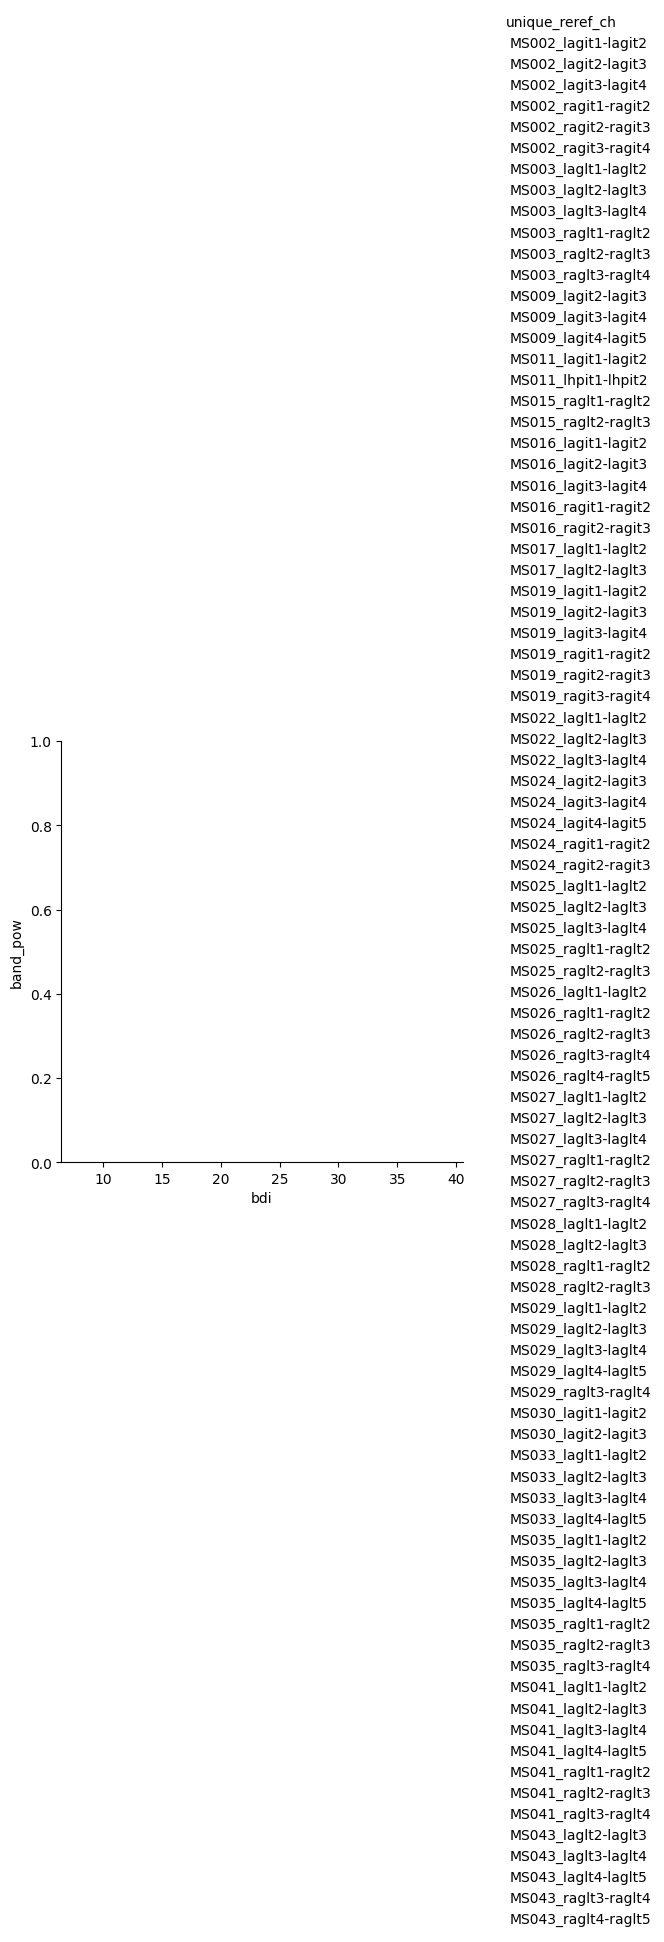

In [101]:
sns.lmplot(data=scatter_data,x='bdi',y='band_pow',hue='unique_reref_ch',scatter=False)
# sns.lmplot(data=scatter_data,x='bdi',y='band_pow',scatter=True)
# sns.lmplot(data=scatter_data,x='band_pow',y='decisionCPE',scatter=False)

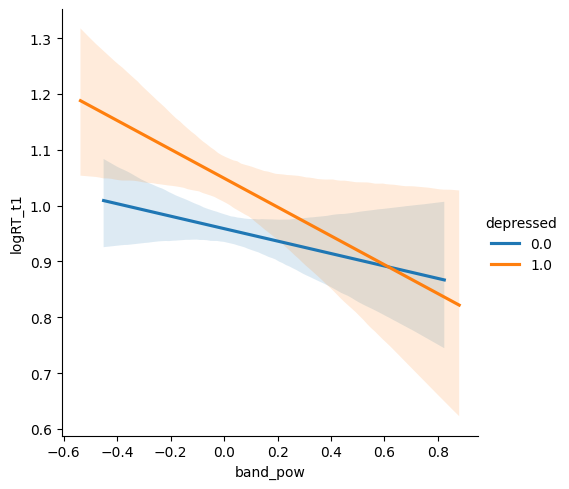

In [53]:
sns.lmplot(data=scatter_data,x='band_pow',y='logRT_t1',hue='depressed',scatter=False)

In [45]:
dep_scatter = scatter_data[scatter_data.depressed == 1]
nodep_scatter = scatter_data[scatter_data.depressed == 0]

<Axes: xlabel='band_pow', ylabel='decisionCPE'>

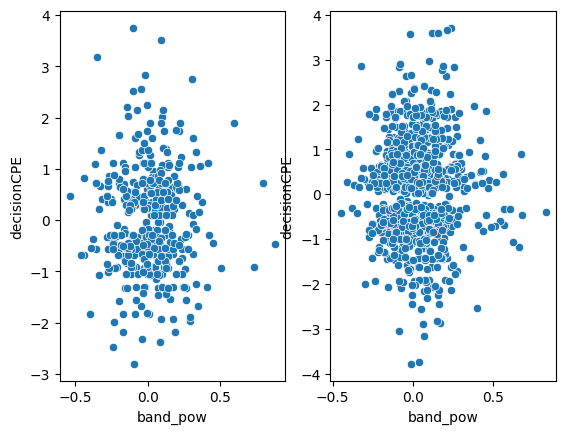

In [49]:
fig,(ax1,ax2) = plt.subplots(1,2)
sns.scatterplot(ax=ax1,data=dep_scatter,x='band_pow',y='decisionCPE')
sns.scatterplot(ax=ax2,data=nodep_scatter,x='band_pow',y='decisionCPE')


Text(0.5, 1.0, 'Low BDI')

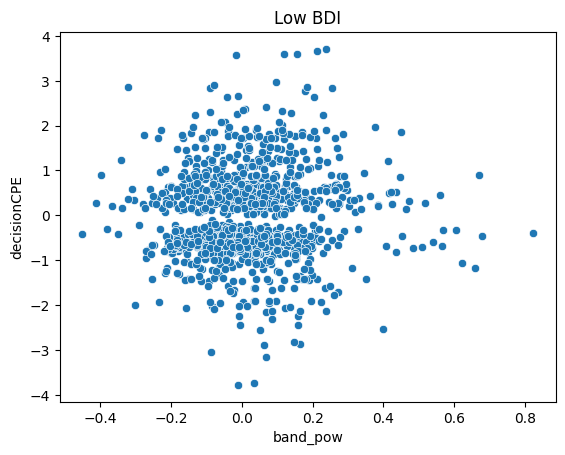

In [47]:
sns.scatterplot(data=nodep_scatter,x='band_pow',y='decisionCPE')
plt.title('Low BDI')

In [ ]:
sns.scatterplot(data=dep_scatter,x='band_pow',y='decisionCPE')
plt.title('High BDI')

In [ ]:
sns.scatterplot(data=dep_scatter,x='band_pow',y='decisionCPE')
plt.title('High BDI')

## ROI Models - CPE:Beta Interaction 

In [69]:
plot_rois = ['ofc','acc','ains','pins','amy','hpc','dmpfc','dlpfc','vmpfc','vlpfc','motor']

In [82]:
###### define vars for model
plot_vars = ['decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

interaction_plot_models = {}

for roi in plot_rois:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,plot_vars,outcome_var,rand_eff_var)
    interaction_plot_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
# roi_cpe_pvals = [list(interaction_plot_models[roi]['model_fit'].pvalues[1:len(plot_vars)+1]) for roi in plot_rois]

# list(zip(plot_rois,roi_cpe_pvals))

In [86]:
interaction_plot_models['amy']['model_fit'].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                     MixedLM         Dependent Variable:         logRT_t1  
No. Observations:          12440           Method:                     REML      
No. Groups:                90              Scale:                      0.1270    
Min. group size:           65              Log-Likelihood:             -5178.6752
Max. group size:           149             Converged:                  No        
Mean group size:           138.2                                                 
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               1.036    0.025 41.676 0.000  0.987  1.085
decisionCPE                             0.026    0.018  1.436 0.151 -0.009  0.062
band_pow                               -0.046    0.021 -2.159 0.031 -0.087 -0.004
decisionCPE:band_pow                    0.056    0.024  2.281 0.023  0.008  0.104
Group Var                               0.054    0.019                           
Group x decisionCPE Cov                -0.001    0.020                           
decisionCPE Var                         0.027                                    
Group x band_pow Cov                   -0.000    0.013                           
decisionCPE x band_pow Cov             -0.000                                    
band_pow Var                            0.005    0.009                           
Group x decisionCPE:band_pow Cov       -0.006    0.016                           
decisionCPE x decisionCPE:band_pow Cov -0.006    0.024                           
band_pow x decisionCPE:band_pow Cov    -0.000    0.019                           
decisionCPE:band_pow Var                0.007    0.040                           
=================================================================================

"""

In [89]:
interaction_plot_models['amy']['model_fit'].pvalues['decisionCPE:band_pow']

Intercept                                 0.000000e+00
decisionCPE                               1.509842e-01
band_pow                                  3.082685e-02
decisionCPE:band_pow                      2.254417e-02
Group Var                                 7.568844e-16
Group x decisionCPE Cov                   8.768683e-01
decisionCPE Var                                    NaN
Group x band_pow Cov                      9.640848e-01
decisionCPE x band_pow Cov                         NaN
band_pow Var                              1.410871e-01
Group x decisionCPE:band_pow Cov          2.916845e-01
decisionCPE x decisionCPE:band_pow Cov    4.951786e-01
band_pow x decisionCPE:band_pow Cov       9.714700e-01
decisionCPE:band_pow Var                  6.443938e-01
dtype: float64

In [107]:
roi_cpe_pvalues = []
roi_int_slopes = []

for key in interaction_plot_models.keys():

    roi_cpe_pvalues.append((key,interaction_plot_models[key]['model_fit'].pvalues['decisionCPE:band_pow']))
    roi_int_slopes.append(pd.DataFrame({'unique_reref_ch':
                                        interaction_plot_models[key]['model_fit'].random_effects.keys(),
                                        'roi':
                                        [key]*len(interaction_plot_models[key]['model_fit'].random_effects.keys()),
                                        'cpe_beta_slope':[val['decisionCPE:band_pow'] for 
                                        val in interaction_plot_models[key]['model_fit'].random_effects.values()]}))
                                        

        
    
roi_cpe_pvalues

[('ofc', 0.008167935310486256),
 ('acc', 0.44379397528059683),
 ('ains', 0.002169326574180787),
 ('pins', 0.25726688339218784),
 ('amy', 0.02254417446750595),
 ('hpc', 0.38985689457877404),
 ('dmpfc', 0.19134948114991757),
 ('dlpfc', 0.4680315341257032),
 ('vmpfc', 0.5044320899332861),
 ('vlpfc', 0.19603392406004427),
 ('motor', 0.940750126453178)]

In [137]:
interaction_plot_df = pd.concat(roi_int_slopes)
interaction_plot_df['subj_id'] = [val.split('_')[0] for val in interaction_plot_df.unique_reref_ch]
interaction_plot_df['bdi'] = [int(subj_info_df[subj_info_df.subj_id == subj_id].bdi) for subj_id in interaction_plot_df.subj_id]
interaction_plot_df

,unique_reref_ch,roi,cpe_beta_slope,subj_id,bdi
0,MS002_lloif1-lloif2,ofc,0.056539,MS002,14
1,MS002_lloif2-lloif3,ofc,0.037756,MS002,14
2,MS002_lloif3-lloif4,ofc,0.067277,MS002,14
3,MS002_lmoif1-lmoif2,ofc,0.069364,MS002,14
4,MS002_lmoif2-lmoif3,ofc,-0.010298,MS002,14
...,...,...,...,...,...
13,MS022_lplfo3-lplfo4,motor,0.010830,MS022,10
14,MS022_lplfo4-lplfo5,motor,0.040625,MS022,10
15,MS022_lplfo5-lplfo6,motor,0.016796,MS022,10
16,MS030_lpipo5-lpipo6,motor,-0.012634,MS030,19


### BARPLOTS BY BDI

In [122]:
subj_means_plot = ains_beta_results.groupby('subj_id').agg('mean')
subj_means_plot

,ains_cpe,ains_beta_pow,ains_cpe_beta
subj_id,,,
MS002,-0.009383,0.061723,0.011894
MS003,-0.005117,-0.062546,0.000638
MS009,-0.016068,0.022116,0.018300
MS015,0.000503,-0.072003,0.003043
MS017,-0.002265,-0.050070,0.001129
MS024,0.001191,0.030788,0.000267
MS028,-0.000539,0.041942,0.004716
MS029,0.027466,-0.012854,-0.030364
MS030,-0.015131,-0.040902,0.012208


In [124]:
roi_subj = subj_means_plot.index.values.tolist()
roi_subj

['MS002',
 'MS003',
 'MS009',
 'MS015',
 'MS017',
 'MS024',
 'MS028',
 'MS029',
 'MS030',
 'MS035',
 'MS041']

In [128]:
roi_subj_bdi = subj_info_df.bdi[subj_info_df.subj_id.isin(roi_subj)].tolist()

In [129]:
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_beta_pow.values)
print(p_r)

0.37232433456616254


In [130]:
subj_means_plot['bdi'] = roi_subj_bdi
subj_means_plot

,ains_cpe,ains_beta_pow,ains_cpe_beta,bdi
subj_id,,,,
MS002,-0.009383,0.061723,0.011894,14
MS003,-0.005117,-0.062546,0.000638,8
MS009,-0.016068,0.022116,0.018300,16
MS015,0.000503,-0.072003,0.003043,26
MS017,-0.002265,-0.050070,0.001129,26
MS024,0.001191,0.030788,0.000267,16
MS028,-0.000539,0.041942,0.004716,13
MS029,0.027466,-0.012854,-0.030364,32
MS030,-0.015131,-0.040902,0.012208,19


In [131]:
high_bdi_cpe_beta = subj_means_plot['ains_beta_pow'][subj_means_plot['bdi']>=20]
low_bdi_cpe_beta = subj_means_plot['ains_beta_pow'][subj_means_plot['bdi']<20]
ttest_ind(low_bdi_cpe_beta,high_bdi_cpe_beta)

TtestResult(statistic=1.2399657799990829, pvalue=0.24634262909804952, df=9.0)

In [132]:
sm.OLS(endog=subj_means_plot.ains_beta_pow.values,exog=sm.add_constant(roi_subj_bdi)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.8814
Date:                Wed, 15 May 2024   Prob (F-statistic):              0.372
Time:                        20:32:58   Log-Likelihood:                 17.445
No. Observations:                  11   AIC:                            -30.89
Df Residuals:                       9   BIC:                            -30.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0264      0.045      0.591      0.569      -0.075       0.128
x1            -0.0022      0.002     -0.939      0.372      -0.008       0.003
==============================================================================
Omnibus:                        1.527   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.012
Skew:                          -0.483   Prob(JB):                        0.603
Kurtosis:                       1.871   Cond. No.                         51.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.6001734623392665 0.05091861402477757


Text(0, 0.5, 'CPE:Beta Power Rand Slope')

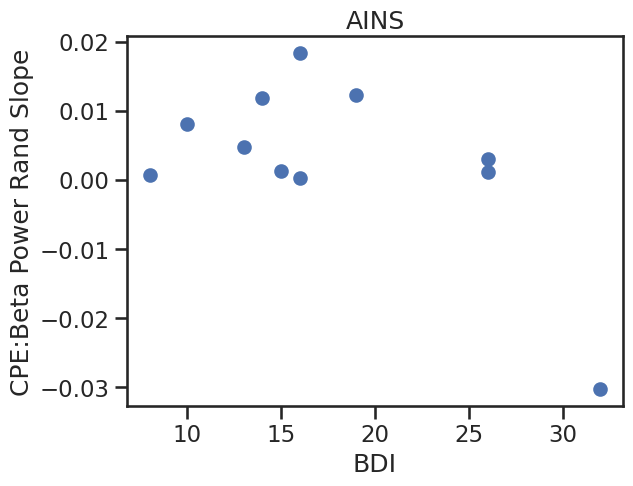

In [133]:
sns.set_context('talk')
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
print(r,p_r)
plt.figure()
plt.scatter(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
plt.title('AINS')
plt.xlabel('BDI')
plt.ylabel('CPE:Beta Power Rand Slope')

## Full Models - CPE:Beta Interaction Betas

In [22]:
# ains_cpe_beta = [val['decisionCPE:band_pow'] for val in roi_fit.random_effects.values()]
beta_model_cpe = [val['decisionCPE'] for val in beta_model_fit.random_effects.values()]
beta_model_cpe

[0.00463242795429546,
 0.005064083489060556,
 0.0038305778078037284,
 0.0028182239358133096,
 -0.0009716551712738294,
 0.0005554165609689189,
 0.0003144194946763033,
 -0.003938429625559319,
 -0.004852310113208646,
 0.0024606301473117267,
 -3.110169302431129e-05,
 0.003210111945263703,
 0.0011811563163256265,
 0.0021015898015958817,
 0.001966468881678017,
 0.022839837356727993,
 -0.0021040210340344564,
 -0.003847409955379315,
 0.0010440004822774766,
 0.0010710430362992295,
 0.01608674190089114,
 0.011513776278508112,
 0.04420402192722936,
 0.017941818824157556,
 0.021329686601278,
 -0.0008247063029399298,
 -0.005229072104031993,
 -0.006688649748477126,
 -0.0026498532396589244,
 -0.0003813789756697125,
 -0.0012410871337444744,
 -0.0035137897556466163,
 -0.007392833349995618,
 0.010554120465165873,
 0.0016576596865397605,
 0.0008896629565679484,
 -0.004654325994038454,
 0.0023223650791637726,
 0.0006185758120806982,
 -0.0012228233756712825,
 0.0008405385005846863,
 0.0013274939663310327,


In [24]:
# ains_cpe_beta = [val['decisionCPE:band_pow'] for val in roi_fit.random_effects.values()]
beta_model_cpe = [val['decisionCPE'] for val in beta_model_fit.random_effects.values()]
beta_model_cpe

[0.003373468622104551,
 0.004776291624533151,
 0.0034962327234416895,
 0.0025575669558159197,
 -0.00034644139156061316,
 0.0005527171113242959,
 0.0003658484046599629,
 -0.0032464614213680585,
 -0.004343699617782558,
 0.0018204003887967687,
 -0.0008833424292118608,
 0.002468018204339765,
 0.0007414369568534044,
 0.002193756374971284,
 0.002934105143249212,
 0.018247582952568873,
 -0.0011678662328283723,
 -0.0022609701404061695,
 0.0016840233733027275,
 0.0024789602230974694,
 0.014052145513543435,
 0.009283129006662338,
 0.03735184007793921,
 0.012228556180563772,
 0.01687414569542773,
 -0.001217650915718669,
 -0.004734751051705362,
 -0.005797688726421187,
 -0.0019736929870356073,
 -5.658616367779799e-06,
 -0.0019307004449752982,
 -0.0021872382993344468,
 -0.007592235826720615,
 0.008296418695527401,
 0.0010604987710697593,
 0.0002231336518815878,
 -0.0037635339528679142,
 0.0028376092288659254,
 9.780535190752125e-05,
 0.00024692917015672774,
 0.001272267766259018,
 0.0004699020115828

In [23]:
beta_cpe_results = pd.DataFrame({'unique_reref_ch':list(beta_model_fit.random_effects.keys()),
                                     'beta_model_cpe':beta_model_cpe})
beta_cpe_results

,unique_reref_ch,beta_model_cpe
0,MS002_lacas1-lacas2,0.004632
1,MS002_lacas2-lacas3,0.005064
2,MS002_lacas3-lacas4,0.003831
3,MS002_lacas4-lacas5,0.002818
4,MS002_lacas5-lacas6,-0.000972
...,...,...
1405,MS043_rmolf11-rmolf12,0.001105
1406,MS043_rmolf2-rmolf3,0.000273
1407,MS043_rmolf5-rmolf6,-0.002141
1408,MS043_rmolf6-rmolf7,-0.000933


In [24]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in beta_cpe_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
beta_cpe_results['roi'] = unique_roi_label
beta_cpe_results['subj_id'] = subj_id_label
beta_cpe_results

,unique_reref_ch,beta_model_cpe,roi,subj_id
0,MS002_lacas1-lacas2,0.004632,acc,MS002
1,MS002_lacas2-lacas3,0.005064,acc,MS002
2,MS002_lacas3-lacas4,0.003831,acc,MS002
3,MS002_lacas4-lacas5,0.002818,acc,MS002
4,MS002_lacas5-lacas6,-0.000972,acc,MS002
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,0.001105,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,0.000273,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.002141,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.000933,ofc,MS043


In [25]:
beta_cpe_means_plot = beta_cpe_results.groupby('subj_id').agg('mean')

In [26]:
##### define subset of ROIs to test 
roi_list = ['acc', 'dmpfc', 'amy', 'sts', 'ains', 'vlpfc', 'hpc', 'ofc',
       'pins', 'dlpfc', 'motor', 'vmpfc', 'mcc', 'phg']
beta_cpe_results = beta_cpe_results[beta_cpe_results.roi.isin(roi_list)]
beta_cpe_results


,unique_reref_ch,beta_model_cpe,roi,subj_id
0,MS002_lacas1-lacas2,0.004632,acc,MS002
1,MS002_lacas2-lacas3,0.005064,acc,MS002
2,MS002_lacas3-lacas4,0.003831,acc,MS002
3,MS002_lacas4-lacas5,0.002818,acc,MS002
4,MS002_lacas5-lacas6,-0.000972,acc,MS002
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,0.001105,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,0.000273,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.002141,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.000933,ofc,MS043


In [234]:
beta_cpe_results

,unique_reref_ch,beta_model_cpe,roi,subj_id
0,MS002_lacas1-lacas2,0.004632,acc,MS002
1,MS002_lacas2-lacas3,0.005064,acc,MS002
2,MS002_lacas3-lacas4,0.003831,acc,MS002
3,MS002_lacas4-lacas5,0.002818,acc,MS002
4,MS002_lacas5-lacas6,-0.000972,acc,MS002
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,0.001105,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,0.000273,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.002141,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.000933,ofc,MS043


In [32]:
roi_list = ['hpc', 'amy', 'ains','acc', 'ofc', 'dmpfc', 'vmpfc','vlpfc']

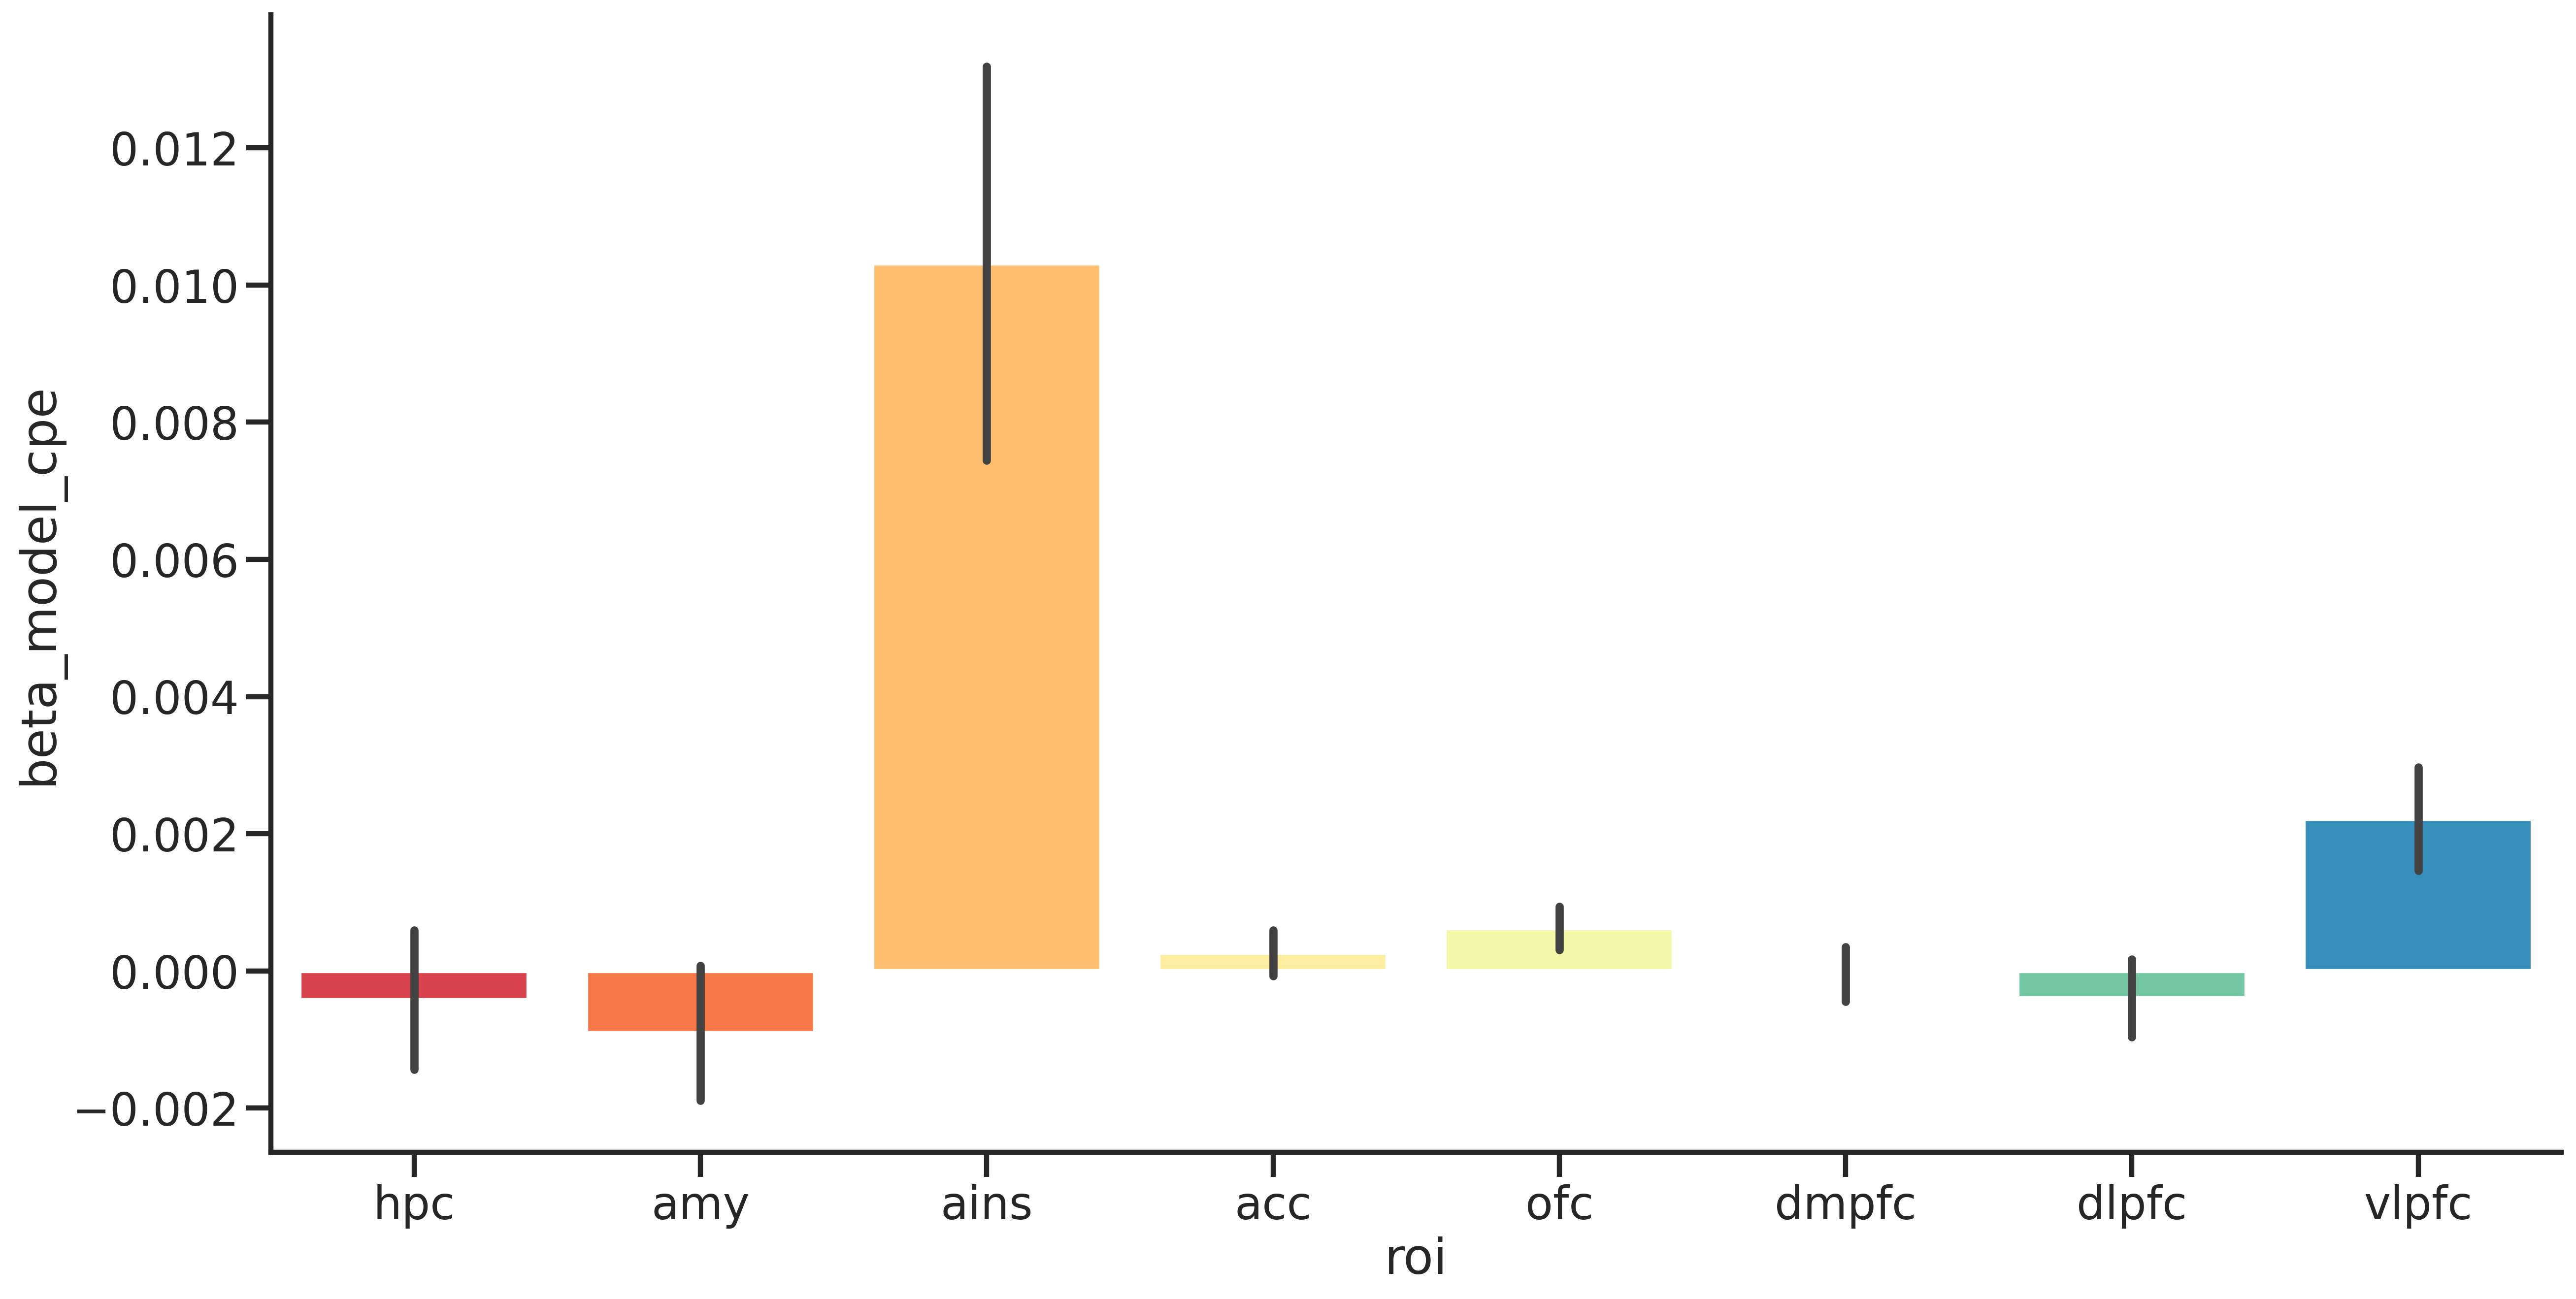

In [55]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

fig_save_dir = f'{base_dir}ephys_analysis/figs/CCN/Beta_Power/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = beta_cpe_results,
              x = beta_cpe_results.roi,
              y = beta_cpe_results.beta_model_cpe,
              palette='Spectral',
              saturation=1,
              order=roi_list,
               errorbar='se',errwidth=4)
sns.despine()
    
plt.savefig(f'{fig_save_dir}/CPE_ROI_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

# Test interaction model on all ROIs

In [101]:
# elec_rand_int = [val['Group'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['Intercept']
# elec_rand_cpe = [val['decisionCPE'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['decisionCPE']
# elec_rand_hfa = [val['hfa_pow'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['hfa_pow']
# elec_rand_cpe_hfa = [val['decisionCPE:hfa_pow'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['decisionCPE:hfa_pow']


# elec_rand_int = [val['Group'] for val in rt_model_fit.random_effects.values()]
# elec_rand_cpe = [val['decisionCPE'] for val in rt_model_fit.random_effects.values()]
# elec_rand_hfa = [val['hfa_pow'] for val in rt_model_fit.random_effects.values()]
# elec_rand_cpe_hfa = [val['decisionCPE:hfa_pow'] for val in rt_model_fit.random_effects.values()]


elec_rand_int = [val['Group'] for val in rt_model_fit.random_effects.values()]
elec_rand_cpe = [val['decisionCPE'] for val in rt_model_fit.random_effects.values()]
elec_rand_beta = [val['band_pow'] for val in rt_model_fit.random_effects.values()]
elec_rand_cpe_beta = [val['decisionCPE:band_pow'] for val in rt_model_fit.random_effects.values()]





In [102]:
rt_cpe_beta_results = pd.DataFrame({'unique_reref_ch':list(rt_model_fit.random_effects.keys()),
                                     'rand_intercepts':elec_rand_int,
                                     'rand_cpe_slopes':elec_rand_cpe,
                                  'rand_beta_slopes':elec_rand_beta,
                                  'rand_cpe_beta_slopes':elec_rand_cpe_beta})
rt_cpe_beta_results

,unique_reref_ch,rand_intercepts,rand_cpe_slopes,rand_beta_slopes,rand_cpe_beta_slopes
0,MS002_lacas1-lacas2,-0.268533,-0.013668,0.021148,0.004892
1,MS002_lacas2-lacas3,-0.268945,-0.014081,0.009678,0.004766
2,MS002_lacas3-lacas4,-0.269037,-0.014022,0.032025,0.005127
3,MS002_lacas4-lacas5,-0.267814,-0.013534,0.007933,0.008504
4,MS002_lacas5-lacas6,-0.267204,-0.014892,-0.001917,0.013935
...,...,...,...,...,...
1499,MS043_rmolf11-rmolf12,-0.311251,0.008678,0.012146,0.008367
1500,MS043_rmolf2-rmolf3,-0.311050,0.008403,0.013601,0.000816
1501,MS043_rmolf5-rmolf6,-0.310901,0.008007,0.025057,0.011264
1502,MS043_rmolf6-rmolf7,-0.312145,0.008948,0.011569,0.011853


In [103]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in rt_cpe_beta_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
rt_cpe_beta_results['roi'] = unique_roi_label
rt_cpe_beta_results['subj_id'] = subj_id_label
rt_cpe_beta_results


,unique_reref_ch,rand_intercepts,rand_cpe_slopes,rand_beta_slopes,rand_cpe_beta_slopes,roi,subj_id
0,MS002_lacas1-lacas2,-0.268533,-0.013668,0.021148,0.004892,acc,MS002
1,MS002_lacas2-lacas3,-0.268945,-0.014081,0.009678,0.004766,acc,MS002
2,MS002_lacas3-lacas4,-0.269037,-0.014022,0.032025,0.005127,acc,MS002
3,MS002_lacas4-lacas5,-0.267814,-0.013534,0.007933,0.008504,acc,MS002
4,MS002_lacas5-lacas6,-0.267204,-0.014892,-0.001917,0.013935,acc,MS002
...,...,...,...,...,...,...,...
1499,MS043_rmolf11-rmolf12,-0.311251,0.008678,0.012146,0.008367,vlpfc,MS043
1500,MS043_rmolf2-rmolf3,-0.311050,0.008403,0.013601,0.000816,ofc,MS043
1501,MS043_rmolf5-rmolf6,-0.310901,0.008007,0.025057,0.011264,ofc,MS043
1502,MS043_rmolf6-rmolf7,-0.312145,0.008948,0.011569,0.011853,ofc,MS043


In [104]:
rt_cpe_beta_results['roi'].value_counts()

dmpfc            199
acc              176
ofc              164
sts              111
hpc               95
dlpfc             92
amy               90
temporal          83
vlpfc             76
ains              51
pins              50
thalamus          44
mcc               28
phg               23
parietal          21
motor             18
vmpfc             17
temporal pole     17
caudate            6
pcc                1
Name: roi, dtype: int64

In [105]:
##### define subset of ROIs to test 
roi_list = ['hpc', 'amy', 'ains','acc', 'ofc', 'dmpfc', 'dlpfc','vlpfc']

In [106]:
rt_cpe_beta_plot = rt_cpe_beta_results.copy()
# good_roi = full_hfa_model_results['roi'].value_counts().index[full_hfa_model_results['roi'].value_counts()>20].to_list()
rt_cpe_beta_plot = rt_cpe_beta_plot[rt_cpe_beta_plot.roi.isin(roi_list)]
rt_cpe_beta_plot


,unique_reref_ch,rand_intercepts,rand_cpe_slopes,rand_beta_slopes,rand_cpe_beta_slopes,roi,subj_id
0,MS002_lacas1-lacas2,-0.268533,-0.013668,0.021148,0.004892,acc,MS002
1,MS002_lacas2-lacas3,-0.268945,-0.014081,0.009678,0.004766,acc,MS002
2,MS002_lacas3-lacas4,-0.269037,-0.014022,0.032025,0.005127,acc,MS002
3,MS002_lacas4-lacas5,-0.267814,-0.013534,0.007933,0.008504,acc,MS002
4,MS002_lacas5-lacas6,-0.267204,-0.014892,-0.001917,0.013935,acc,MS002
...,...,...,...,...,...,...,...
1499,MS043_rmolf11-rmolf12,-0.311251,0.008678,0.012146,0.008367,vlpfc,MS043
1500,MS043_rmolf2-rmolf3,-0.311050,0.008403,0.013601,0.000816,ofc,MS043
1501,MS043_rmolf5-rmolf6,-0.310901,0.008007,0.025057,0.011264,ofc,MS043
1502,MS043_rmolf6-rmolf7,-0.312145,0.008948,0.011569,0.011853,ofc,MS043


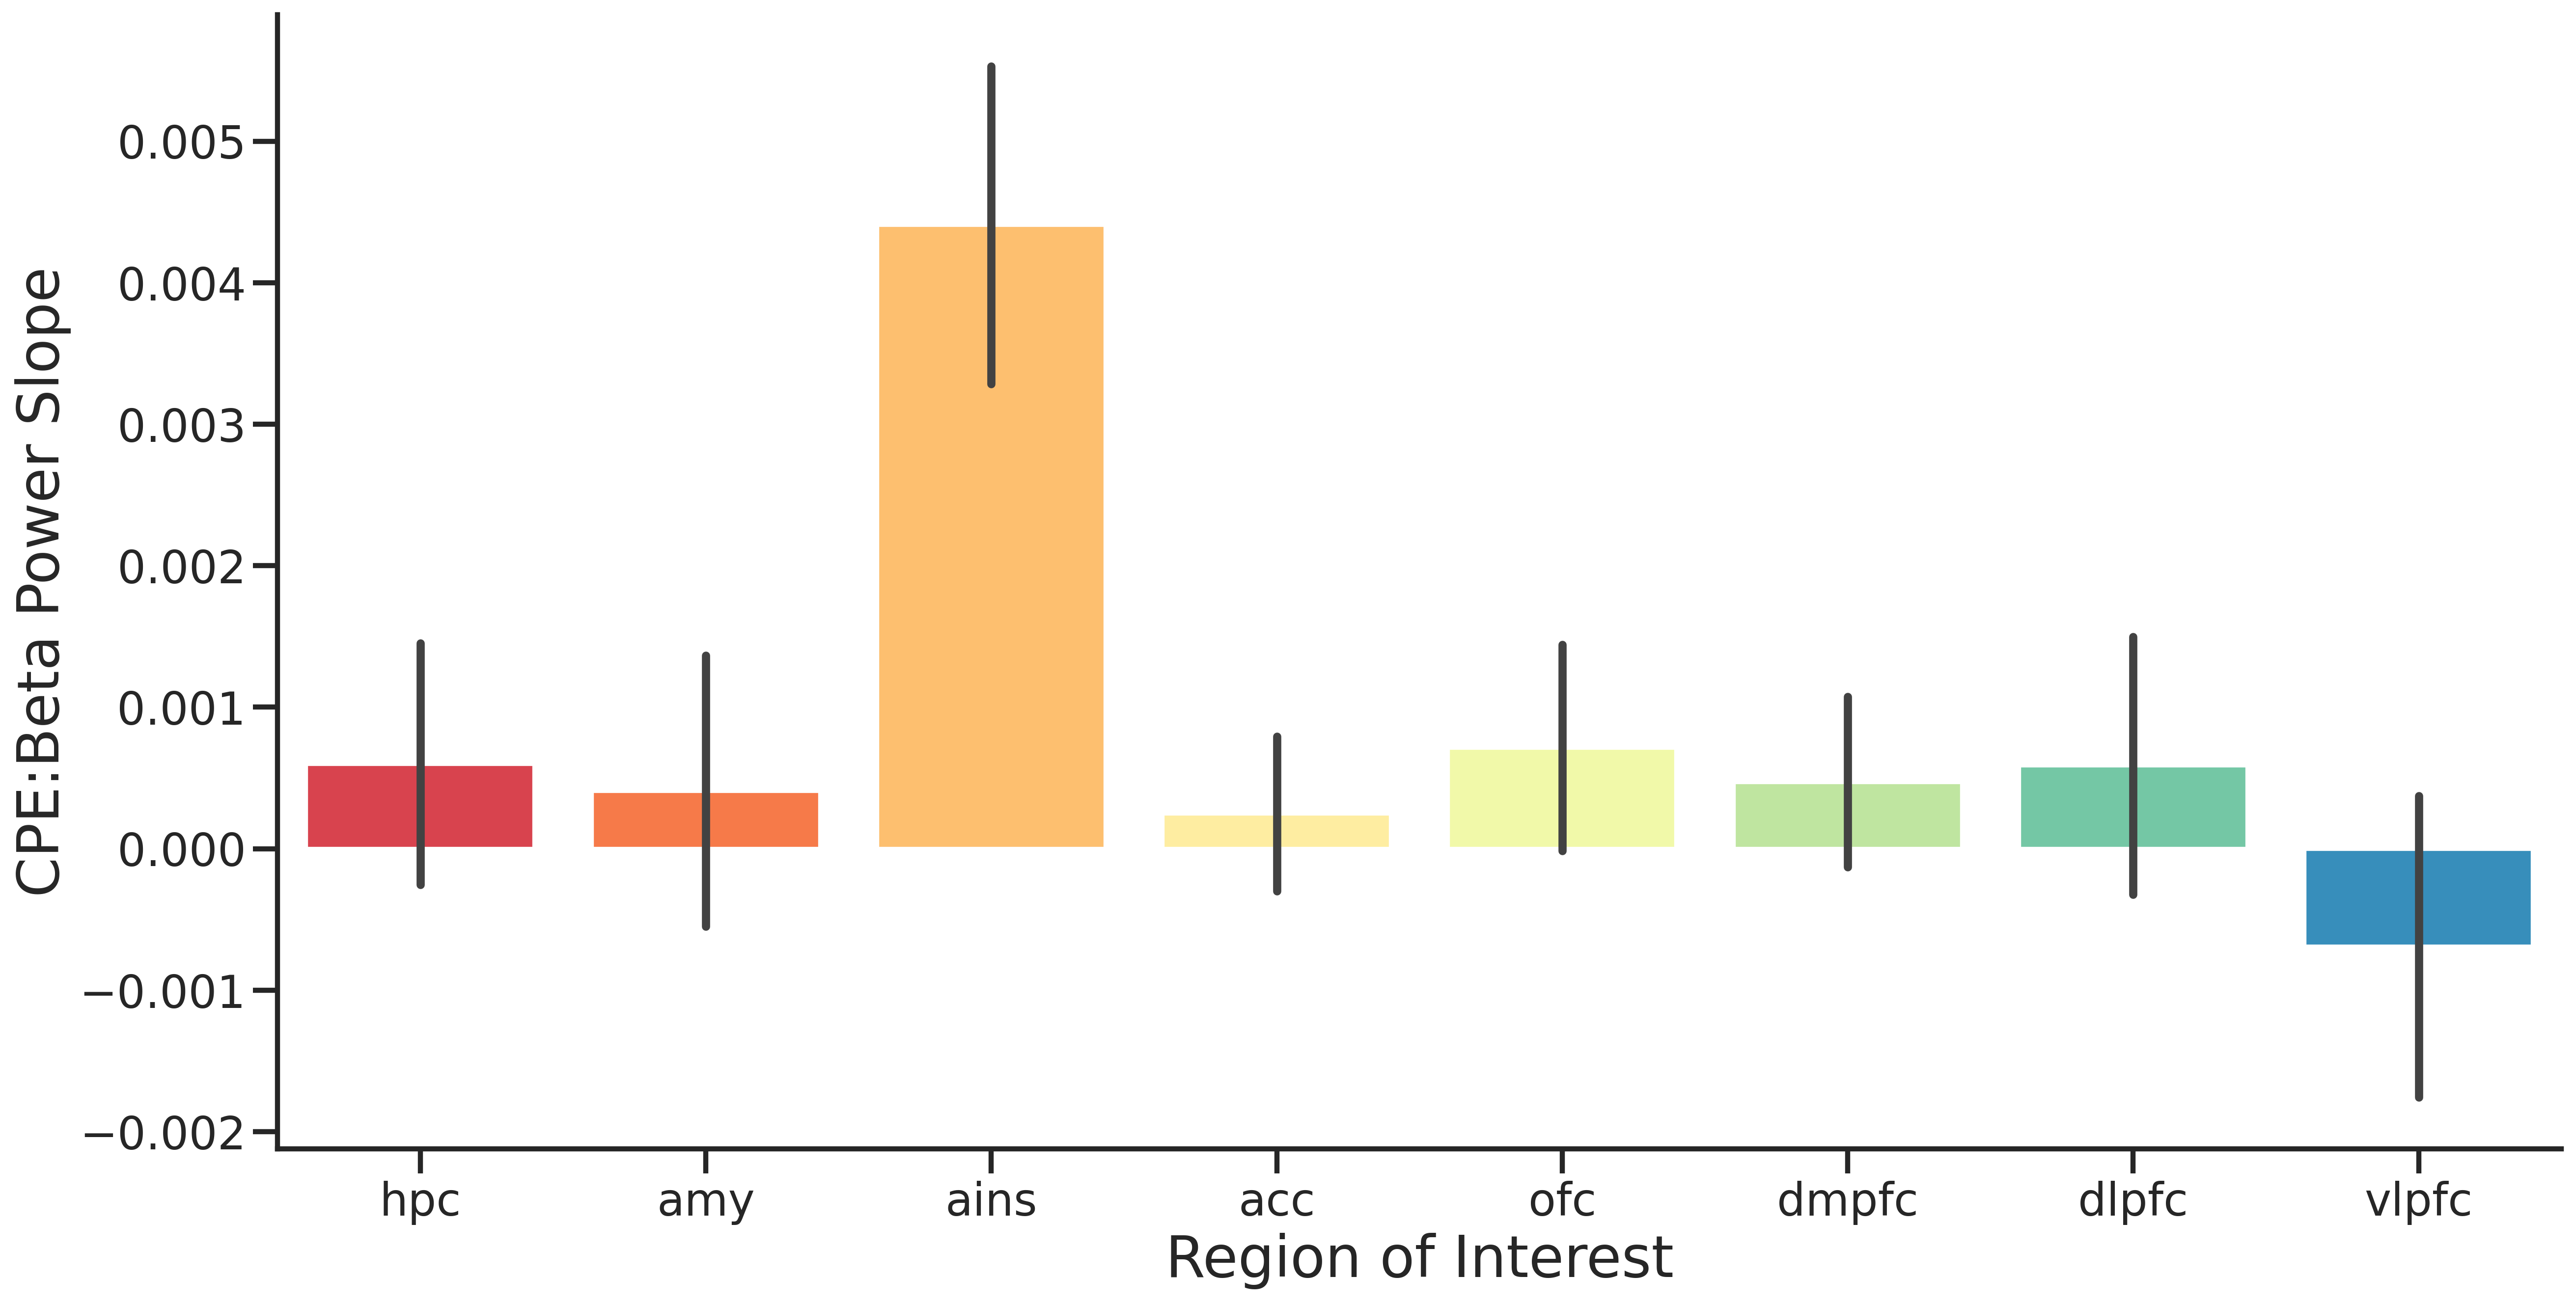

In [107]:

sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

fig_save_dir = f'{base_dir}ephys_analysis/figs/CCN/Beta_Power/'
os.makedirs(fig_save_dir,exist_ok=True)
    

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'Spectral', #tab20c #RdYlGn #viridis
            saturation = 1,
           errwidth=4,
           errorbar='se',
           order=roi_list)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()


# plt.savefig(f'{fig_save_dir}/InteractionBetas_ROI_{date}.pdf', format='pdf', metadata=None,
# bbox_inches=None, pad_inches=0.1,
# facecolor='auto', edgecolor='auto',dpi=500,
# backend=None)



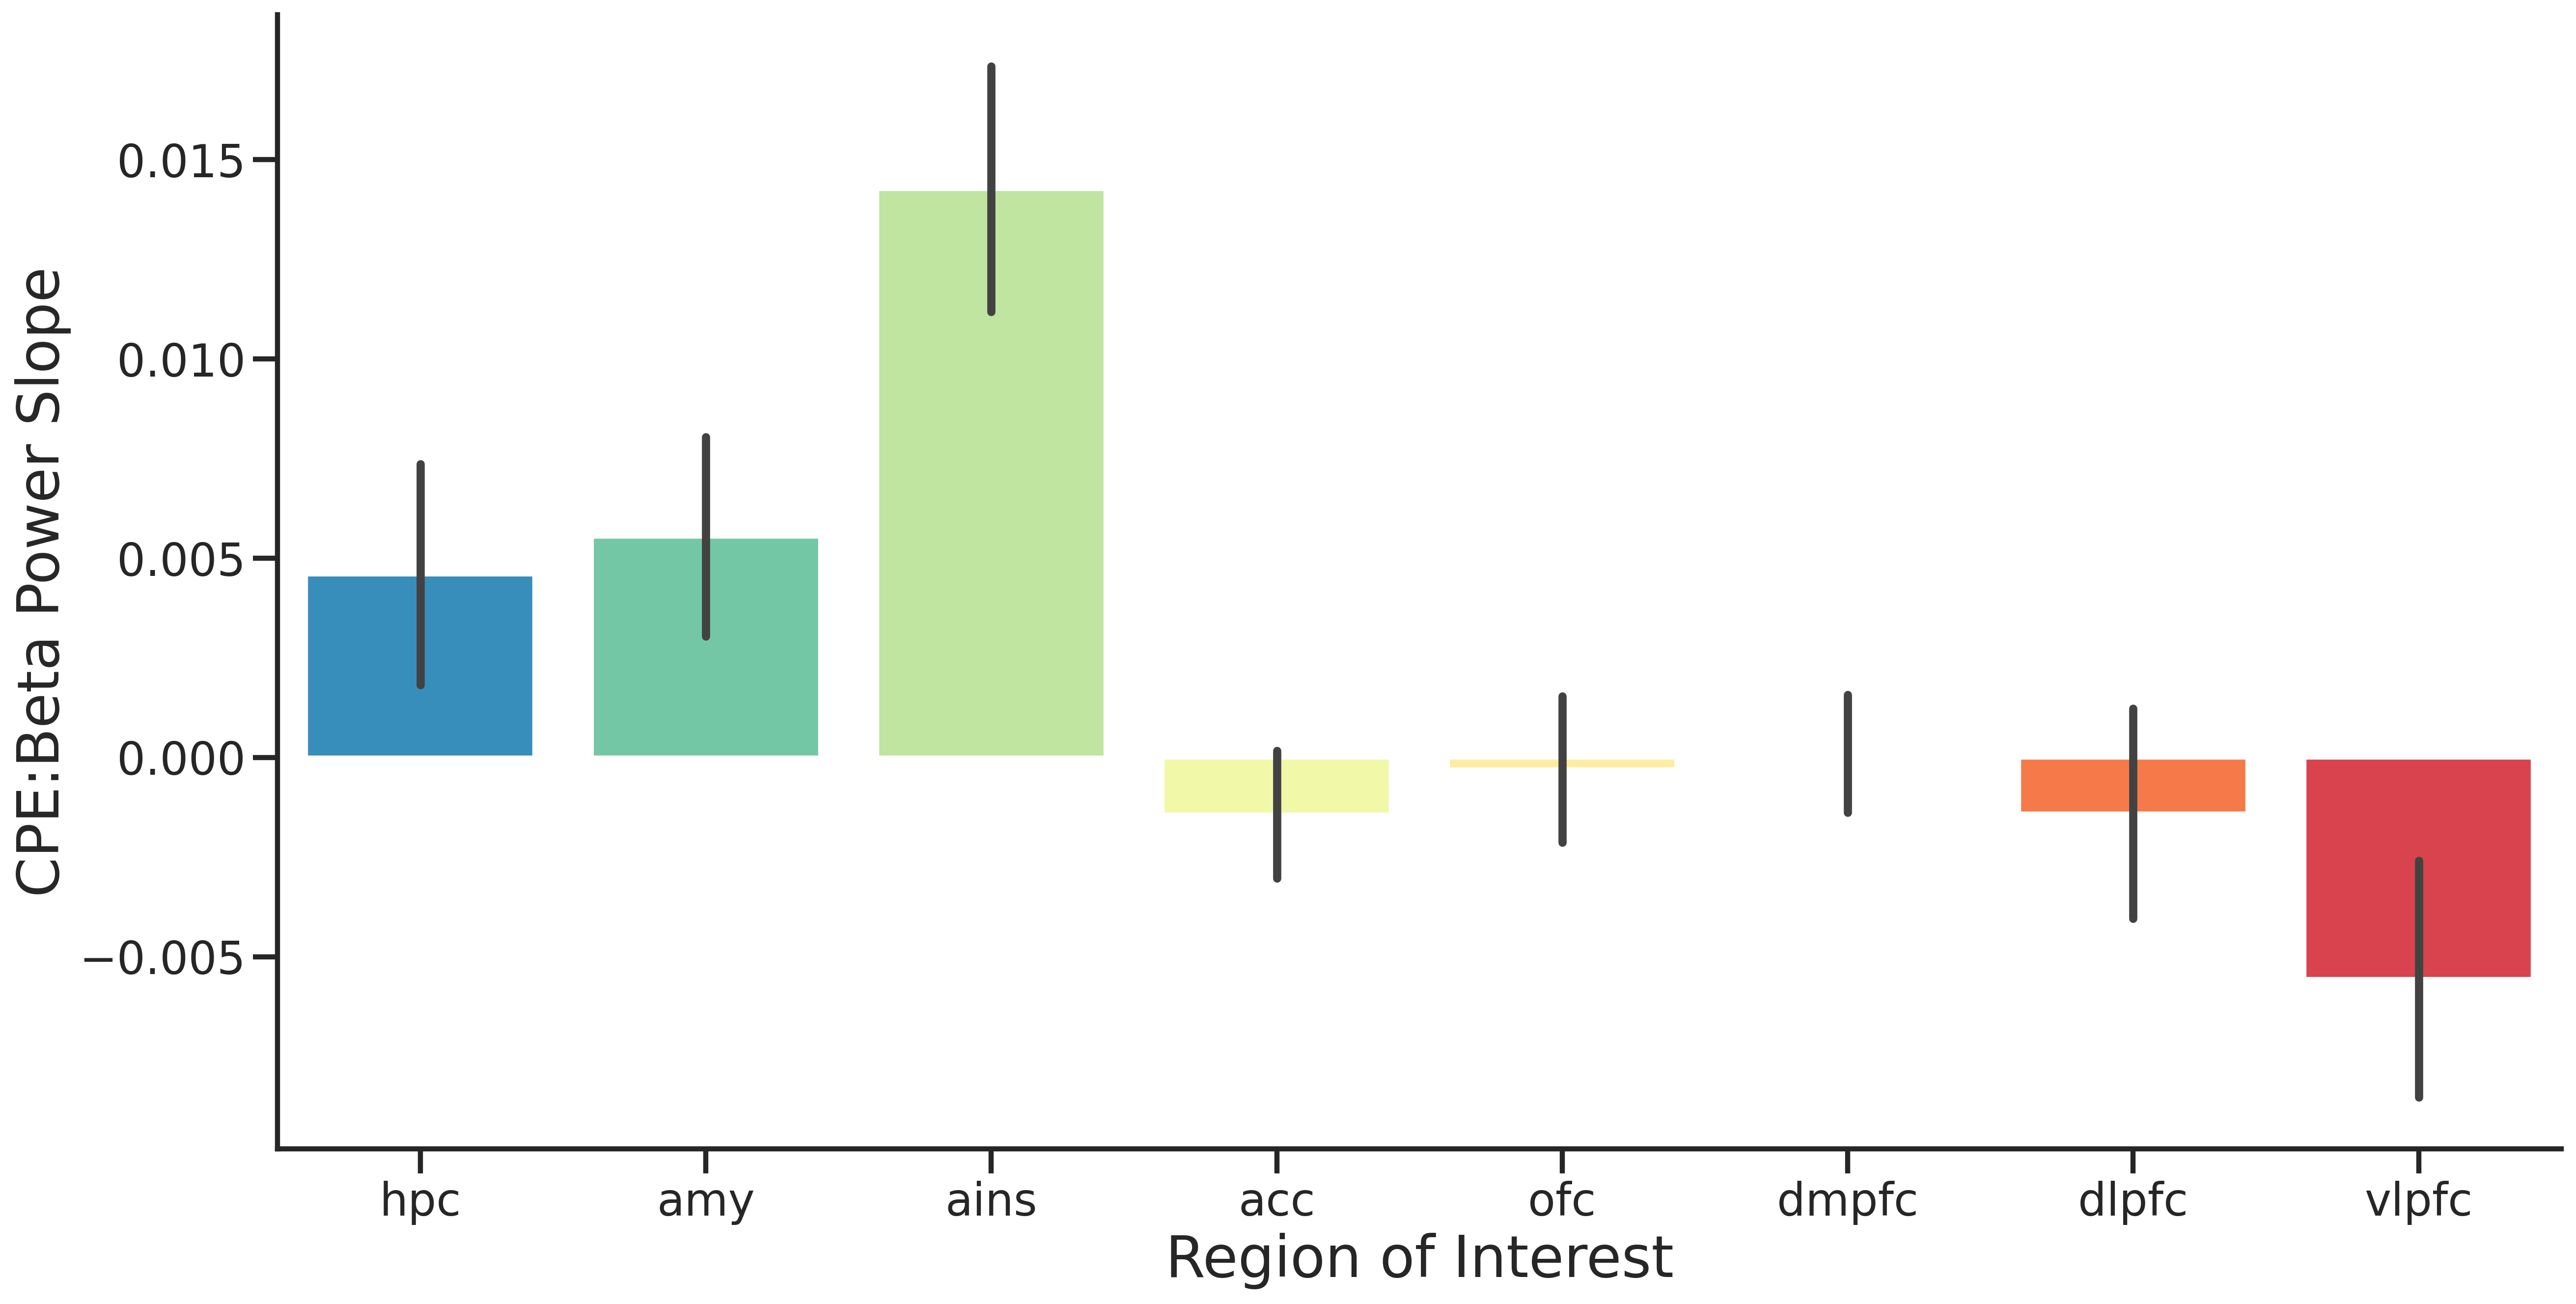

In [231]:

sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'Spectral_r', #tab20c
            saturation = 1,
           errwidth=4,
           errorbar='se',
           order=roi_list)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()

In [ ]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in rt_cpe_beta_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
rt_cpe_beta_results['roi'] = unique_roi_label
rt_cpe_beta_results['subj_id'] = subj_id_label
rt_cpe_beta_results


In [ ]:
rt_cpe_beta_plot = rt_cpe_beta_results.copy()
# good_roi = full_hfa_model_results['roi'].value_counts().index[full_hfa_model_results['roi'].value_counts()>20].to_list()
rt_cpe_beta_plot = rt_cpe_beta_plot[rt_cpe_beta_plot.roi.isin(roi_list)]
rt_cpe_beta_plot

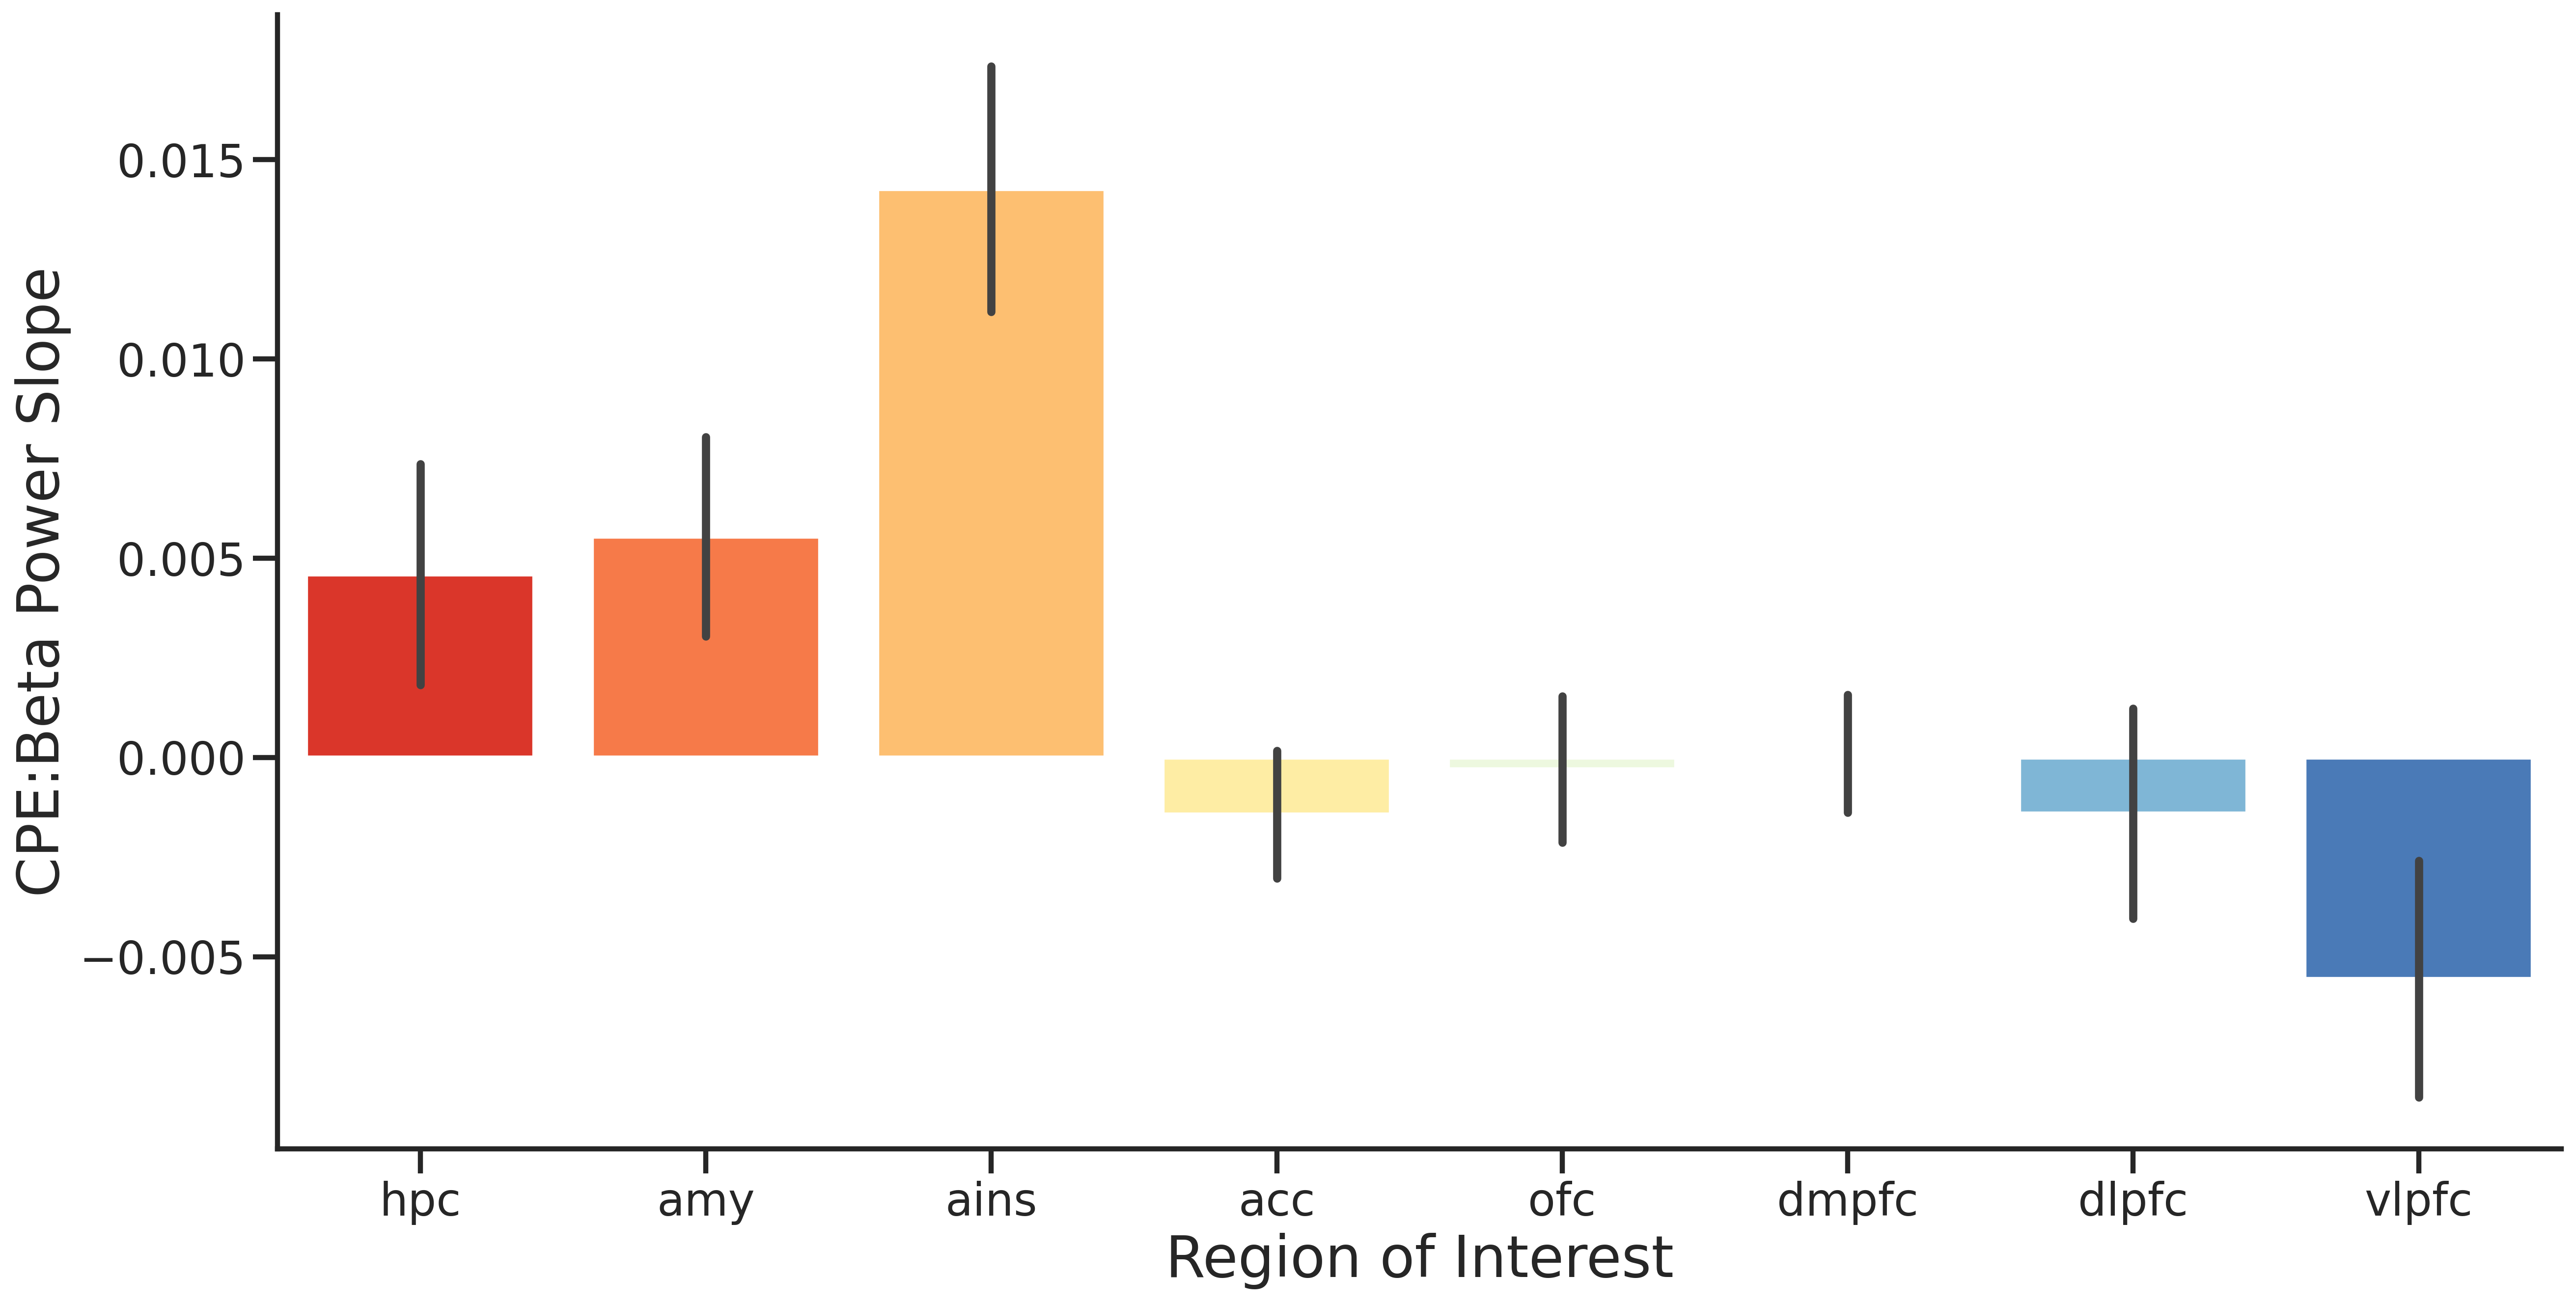

In [232]:

sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'RdYlBu',
            saturation = 1,
            order=roi_list,
           errwidth=4,
           errorbar='se')

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()

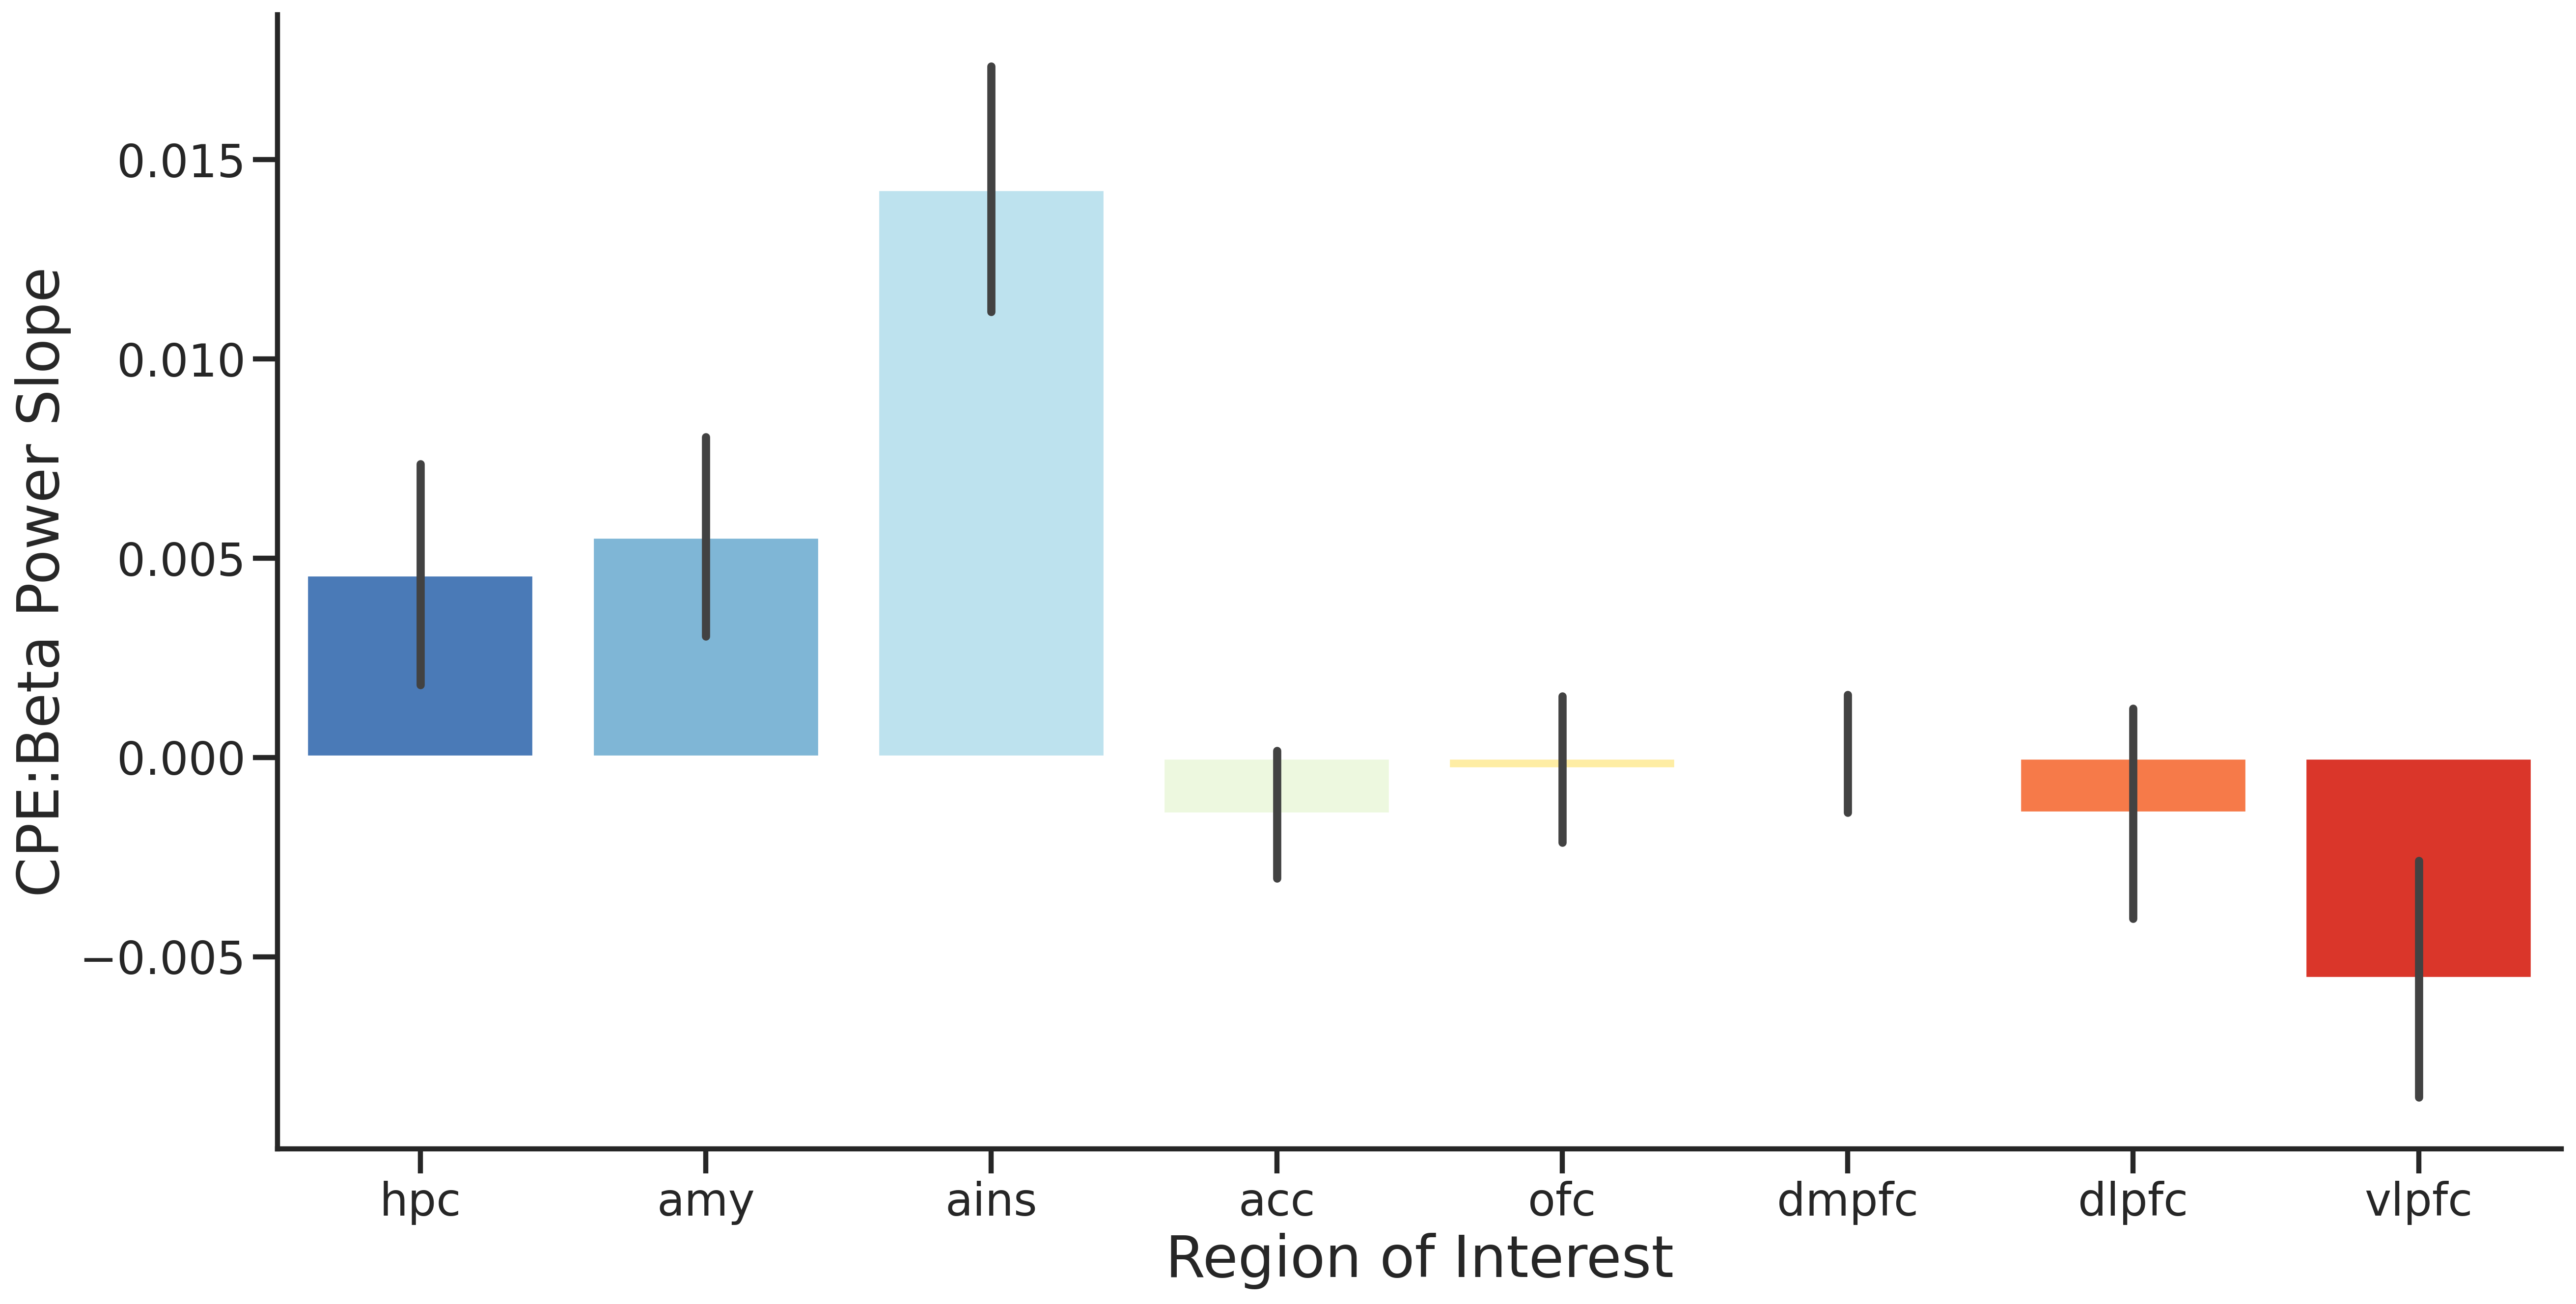

In [233]:
sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'RdYlBu_r',
            order = roi_list,
            saturation = 1,
           errwidth=4,
           errorbar='se')

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()

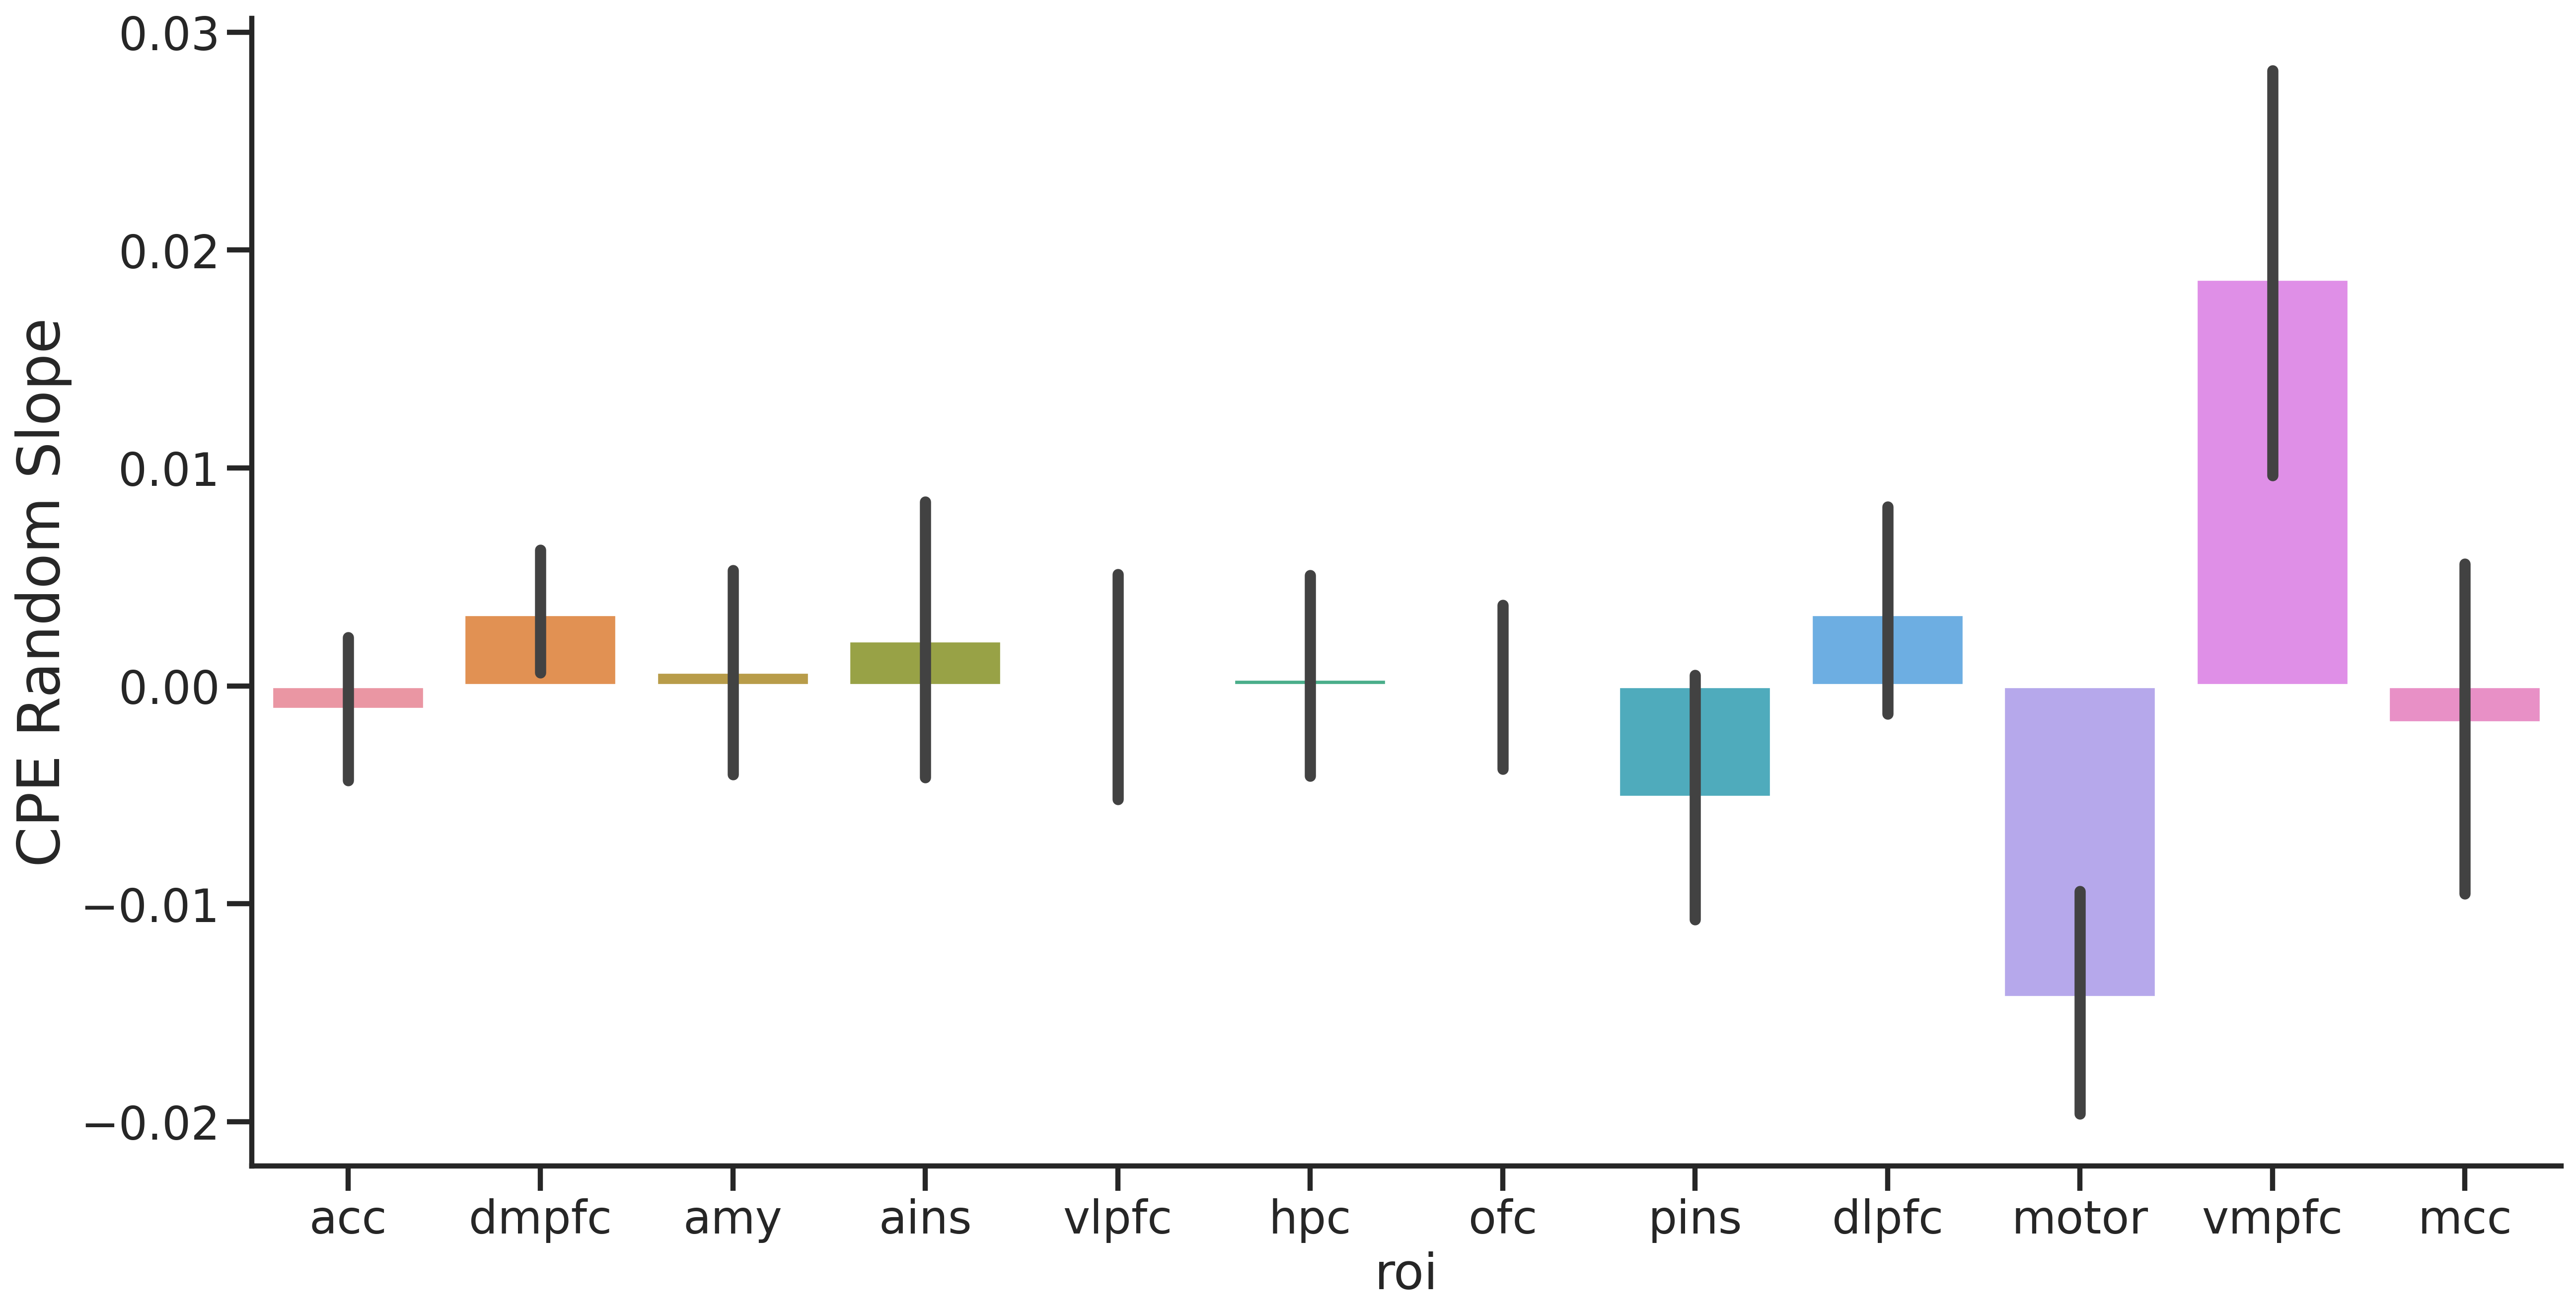

In [42]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,
              x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_slopes)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE Random Slope',fontsize=28,x=0.1)
# plt.xlabel('Region',fontsize=28,y=-0.03)
sns.despine()

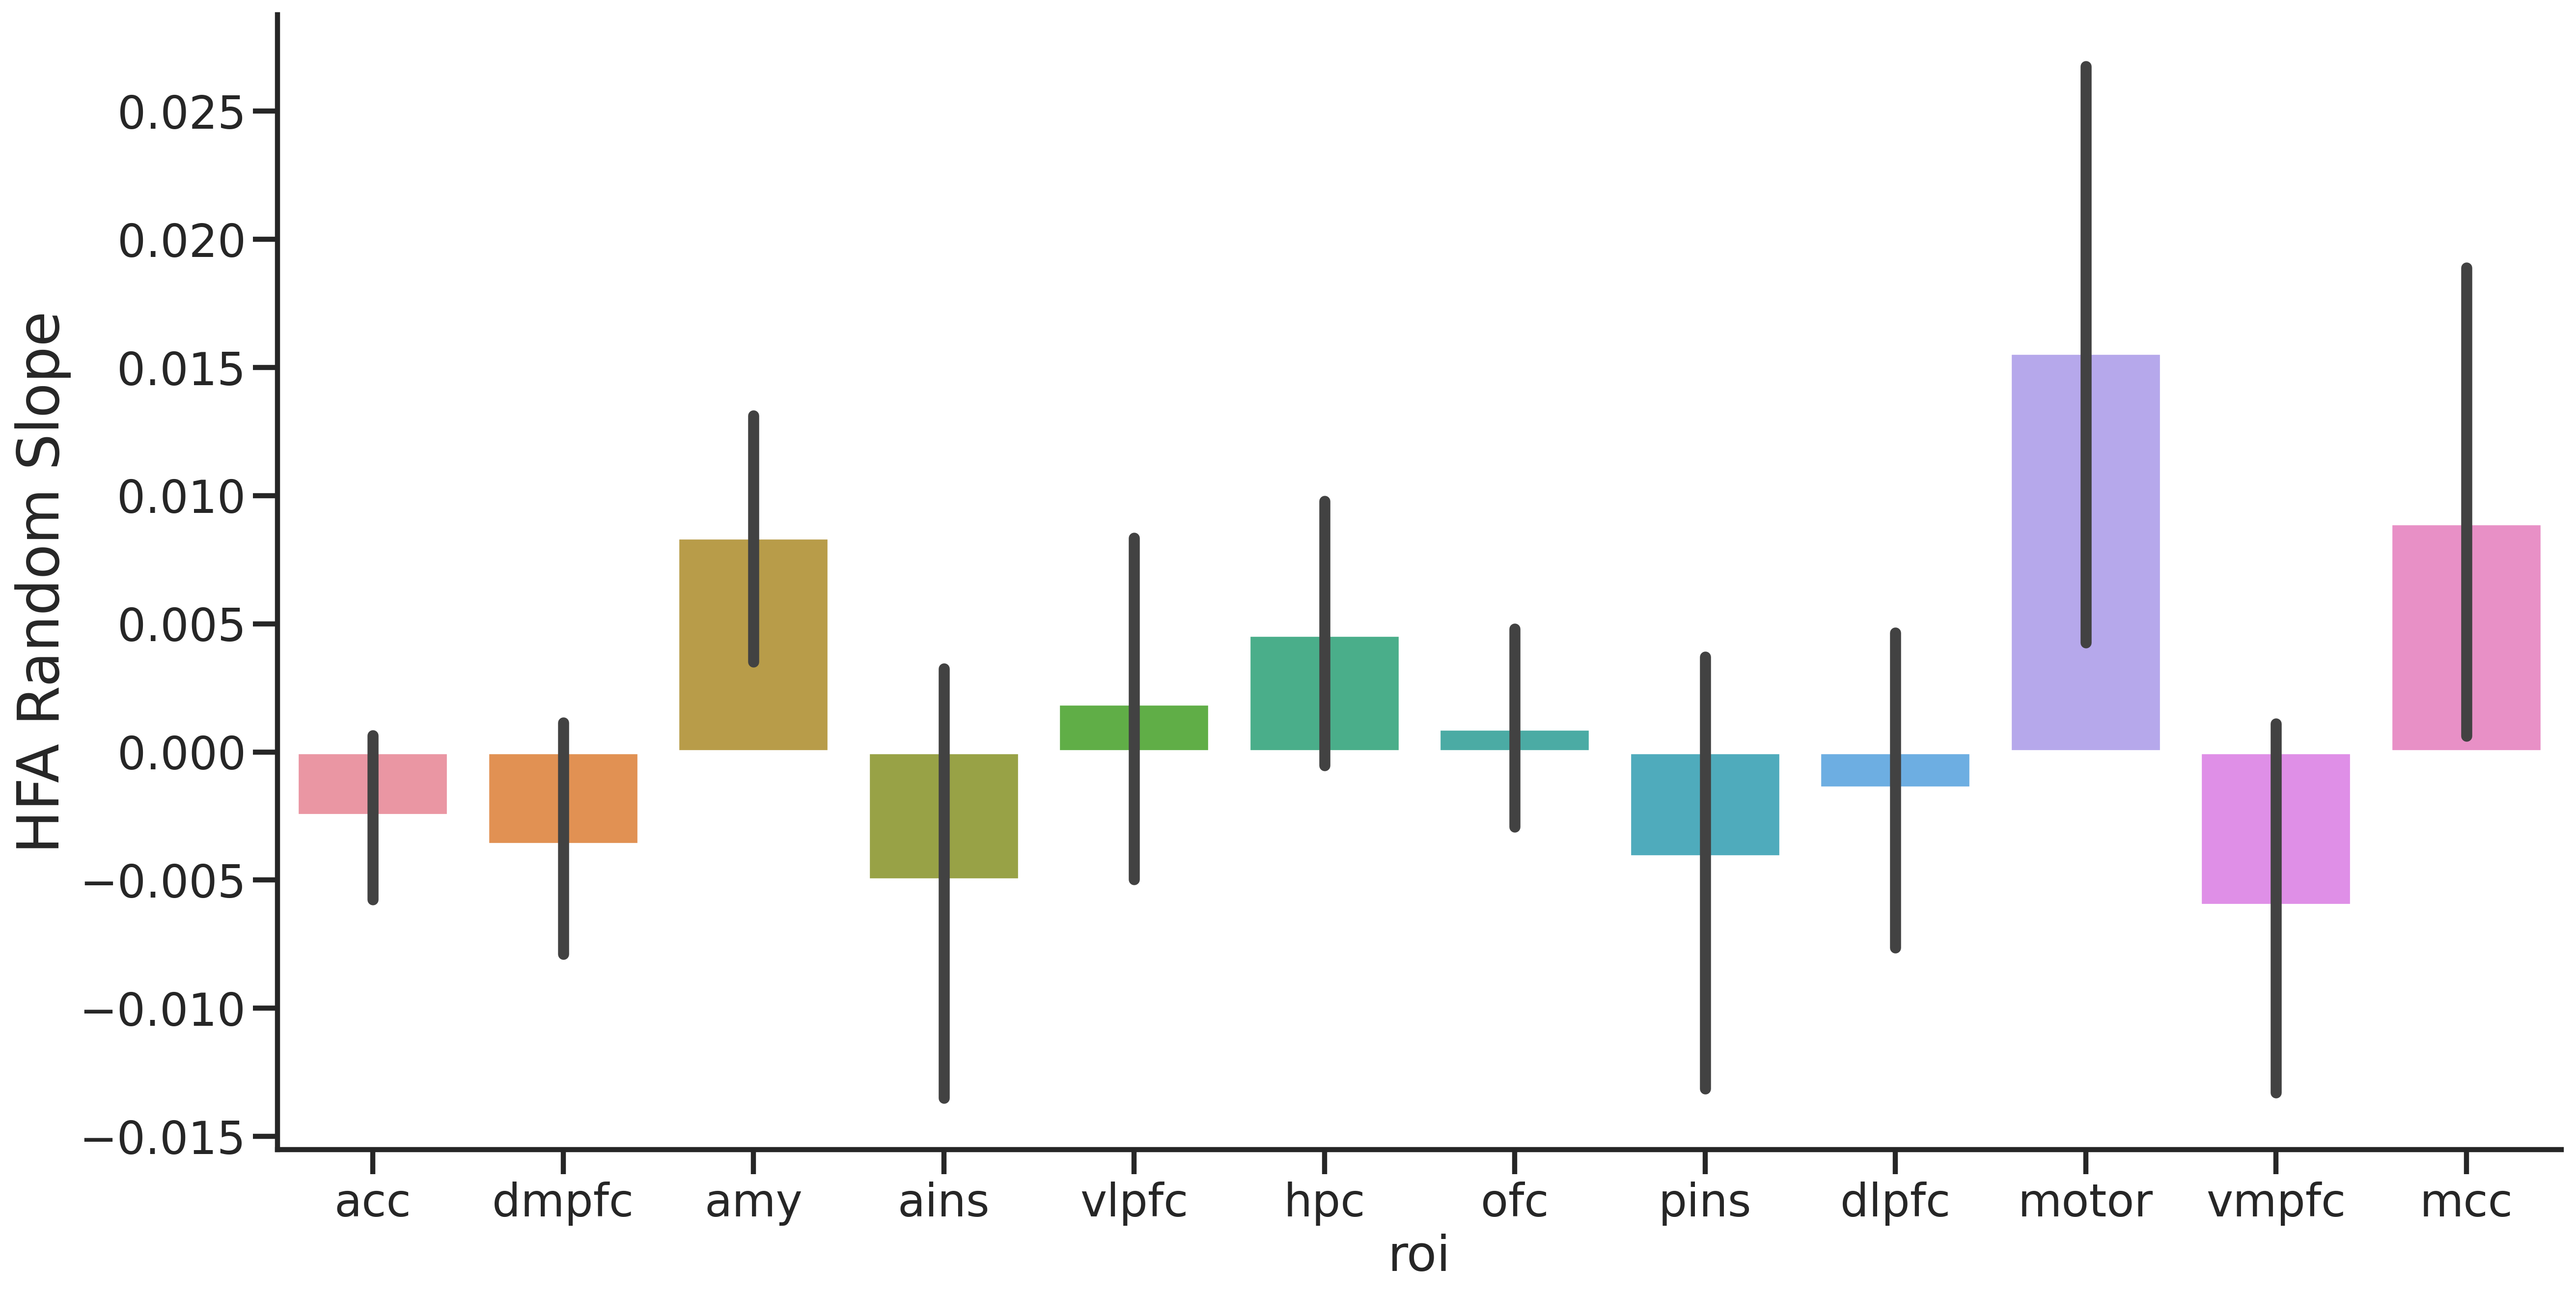

In [44]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,
              x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_beta_slopes)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('HFA Random Slope',fontsize=28,x=0.1)
# plt.xlabel('Region',fontsize=28,y=-0.03)
sns.despine()

In [450]:
subj_means_plot = rt_cpe_hfa_plot.groupby('subj_id').agg('mean')

In [451]:
subj_means_plot

,rand_intercepts,rand_cpe_slopes,rand_hfa_slopes,rand_cpe_hfa_slopes
subj_id,,,,
MS002,-0.276472,-0.011604,0.102205,0.033682
MS003,0.132748,-0.000141,-0.088724,0.002908
MS004,-0.169151,0.010888,0.120725,0.017341
MS009,-0.117387,-0.020632,0.103697,0.011781
MS011,0.184542,-0.028560,-0.024651,0.051579
MS015,0.098363,-0.005786,-0.157425,0.027323
MS016,0.439091,0.017121,-0.016099,0.032696
MS017,0.084068,-0.003172,0.007178,0.026329
MS019,-0.115148,0.014453,0.098954,-0.010265


# Identify ROI beta encoding of CPEs

In [108]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

ains_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
ains_fit = fit_mixed_model(ains_df,roi_vars,outcome_var,rand_eff_var)

    
amy_df = beta_reg_df[(beta_reg_df.roi == 'amy')]
amy_fit = fit_mixed_model(amy_df,roi_vars,outcome_var,rand_eff_var)


In [109]:
ains_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                         MixedLM             Dependent Variable:             logRT_t1  
No. Observations:              6745                Method:                         REML      
No. Groups:                    51                  Scale:                          0.1480    
Min. group size:               65                  Log-Likelihood:                 -3270.0875
Max. group size:               149                 Converged:                      Yes       
Mean group size:               132.3                                                         
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           0.902    0.025 35.705 0.000  0.852  0.951
C(GambleChoice)[T.safe]                             0.032    0.011  2.875 0.004  0.010  0.054
GambleEV                                            0.029    0.008  3.906 0.000  0.015  0.044
decisionCPE                                         0.022    0.007  3.378 0.001  0.009  0.035
band_pow                                           -0.014    0.027 -0.512 0.609 -0.067  0.039
decisionCPE:band_pow                                0.070    0.027  2.572 0.010  0.017  0.123
Group Var                                           0.029    0.014                           
Group x C(GambleChoice)[T.safe] Cov                -0.001    0.007                           
C(GambleChoice)[T.safe] Var                         0.000                                    
Group x GambleEV Cov                               -0.004    0.004                           
C(GambleChoice)[T.safe] x GambleEV Cov              0.000    0.002                           
GambleEV Var                                        0.001    0.001                           
Group x decisionCPE Cov                            -0.000    0.003                           
C(GambleChoice)[T.safe] x decisionCPE Cov          -0.000    0.002                           
GambleEV x decisionCPE Cov                          0.001    0.001                           
decisionCPE Var                                     0.001    0.002                           
Group x band_pow Cov                               -0.005    0.014                           
C(GambleChoice)[T.safe] x band_pow Cov              0.000    0.003                           
GambleEV x band_pow Cov                             0.001    0.005                           
decisionCPE x band_pow Cov                          0.000    0.006                           
band_pow Var                                        0.012                                    
Group x decisionCPE:band_pow Cov                    0.001    0.014                           
C(GambleChoice)[T.safe] x decisionCPE:band_pow Cov -0.000                                    
GambleEV x decisionCPE:band_pow Cov                -0.000    0.003                           
decisionCPE x decisionCPE:band_pow Cov             -0.000    0.003                           
band_pow x decisionCPE:band_pow Cov                -0.001                                    
decisionCPE:band_pow Var                            0.010                                    
=============================================================================================

"""

In [110]:
amy_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                         MixedLM             Dependent Variable:             logRT_t1  
No. Observations:              12440               Method:                         REML      
No. Groups:                    90                  Scale:                          0.1268    
Min. group size:               65                  Log-Likelihood:                 -5093.7379
Max. group size:               149                 Converged:                      No        
Mean group size:               138.2                                                         
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           1.025    0.025 41.668 0.000  0.977  1.074
C(GambleChoice)[T.safe]                             0.015    0.008  1.948 0.051 -0.000  0.030
GambleEV                                            0.017    0.004  4.122 0.000  0.009  0.026
decisionCPE                                         0.024    0.005  5.201 0.000  0.015  0.033
band_pow                                           -0.053    0.024 -2.199 0.028 -0.099 -0.006
decisionCPE:band_pow                                0.049    0.022  2.279 0.023  0.007  0.092
Group Var                                           0.048    0.015                           
Group x C(GambleChoice)[T.safe] Cov                -0.003    0.005                           
C(GambleChoice)[T.safe] Var                         0.000                                    
Group x GambleEV Cov                               -0.001    0.002                           
C(GambleChoice)[T.safe] x GambleEV Cov             -0.000                                    
GambleEV Var                                        0.000    0.001                           
Group x decisionCPE Cov                            -0.000    0.002                           
C(GambleChoice)[T.safe] x decisionCPE Cov          -0.000                                    
GambleEV x decisionCPE Cov                         -0.000    0.001                           
decisionCPE Var                                     0.001    0.001                           
Group x band_pow Cov                                0.002    0.013                           
C(GambleChoice)[T.safe] x band_pow Cov             -0.000    0.009                           
GambleEV x band_pow Cov                            -0.000    0.004                           
decisionCPE x band_pow Cov                         -0.000    0.007                           
band_pow Var                                        0.015    0.083                           
Group x decisionCPE:band_pow Cov                   -0.005    0.012                           
C(GambleChoice)[T.safe] x decisionCPE:band_pow Cov  0.000                                    
GambleEV x decisionCPE:band_pow Cov                 0.000                                    
decisionCPE x decisionCPE:band_pow Cov             -0.000                                    
band_pow x decisionCPE:band_pow Cov                -0.000                                    
decisionCPE:band_pow Var                            0.015                                    
=============================================================================================

"""

In [ ]:
ains_cpe_beta = [val['decisionCPE:band_pow'] for val in ains_fit.random_effects.values()]
amy_cpe_beta = [val['decisionCPE:band_pow'] for val in amy_fit.random_effects.values()]


# rt_cpe_beta_results = pd.DataFrame({'unique_reref_ch':list(rt_model_fit.random_effects.keys()),
#                                      'rand_intercepts':elec_rand_int,
#                                      'rand_cpe_slopes':elec_rand_cpe,
#                                   'rand_beta_slopes':elec_rand_beta,
#                                   'rand_cpe_beta_slopes':elec_rand_cpe_beta})
# rt_cpe_beta_results


# Test encoding by ROI

In [111]:
##### define subset of ROIs to test 
roi_list = ['acc', 'dmpfc', 'amy', 'sts', 'ains', 'vlpfc', 'hpc', 'ofc',
       'pins', 'dlpfc', 'motor', 'vmpfc', 'mcc', 'phg']

In [112]:
var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
ains_beta_model_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
print(ains_beta_model_fit.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    band_pow
No. Observations:     6796       Method:                REML    
No. Groups:           51         Scale:                 0.0495  
Min. group size:      66         Log-Likelihood:        521.3078
Max. group size:      150        Converged:             Yes     
Mean group size:      133.3                                     
----------------------------------------------------------------
                        Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept               0.019    0.005 3.941 0.000  0.009  0.028
decisionCPE             0.010    0.003 2.904 0.004  0.003  0.016
Group Var               0.001    0.001                          
Group x decisionCPE Cov 0.000    0.001                          
decisionCPE Var         0.000    0.001                          



In [113]:

var_list = ['C(GambleChoice)','GambleEV','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:4]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc', [2.622804634658122e-05, 0.6253915080222899, 0.016891066992601178]),
 ('dmpfc',
  [0.00017010759736818198, 0.03546540001576562, 0.0037600836365384873]),
 ('amy', [0.009194883490224825, 0.27498137957579705, 0.20956335577509377]),
 ('sts', [0.0004962237069586804, 0.0888679373646976, 0.4951613234695176]),
 ('ains', [0.02369660750221262, 0.002215469977739317, 0.0014300699878031804]),
 ('vlpfc', [0.003388621712897337, 0.2076987787304989, 0.009785745006113447]),
 ('hpc', [0.07875393540459531, 0.25762195623393136, 0.45647852026959157]),
 ('ofc', [0.5399885805065996, 0.6237714906436296, 0.02031222575181548]),
 ('pins', [0.2911893760581823, 0.1119677502115094, 0.00023457902384822944]),
 ('dlpfc', [0.04385159941678738, 0.9981279235311632, 0.05630825572633072]),
 ('motor', [0.5397152019968245, 0.39113892921499027, 0.0018983347997423381]),
 ('vmpfc', [0.46538205171331193, 0.5776317812819364, 0.09845503259147002]),
 ('mcc', [0.9603599388606612, 0.2167718296838126, 0.40892909528389776]),
 ('

In [114]:
###### TEST CPE ENCODING IN BETA POWER FIRST 
var_list = ['decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:2]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc', [0.02575065767191167]),
 ('dmpfc', [0.008467775493002686]),
 ('amy', [0.7084166960203382]),
 ('sts', [0.4343729902385882]),
 ('ains', [0.003686797880396652]),
 ('vlpfc', [0.012018252556508145]),
 ('hpc', [0.30835992844037563]),
 ('ofc', [0.01580202658226025]),
 ('pins', [0.0002395339945748218]),
 ('dlpfc', [0.09906245504321406]),
 ('motor', [0.002533251787395842]),
 ('vmpfc', [0.09953944451970742]),
 ('mcc', [0.37454982002716]),
 ('phg', [0.29729872144247205])]

In [115]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:7]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc',
  [0.05255013003882445,
   0.0003080724961712926,
   0.10760689223670898,
   2.7313605637215344e-06,
   0.3403004453050442,
   0.8808427804353381]),
 ('dmpfc',
  [0.0005113445596971201,
   7.753396678892665e-10,
   0.1518252472627427,
   4.9580922935776645e-15,
   0.0007524123747376916,
   0.20884346076923388]),
 ('amy',
  [0.03792630282591609,
   3.899741027736684e-05,
   0.7558700103540019,
   1.5402042973559748e-05,
   0.03579069040346429,
   0.3649729959686646]),
 ('sts',
  [0.06935425072041569,
   2.385669110330701e-13,
   0.007394682619990934,
   8.518416295334776e-05,
   nan,
   0.19124269932789362]),
 ('ains',
  [0.012472629540022196,
   0.0003648969729251822,
   0.7236787722404083,
   0.0014033480778292673,
   0.9688495834505066,
   0.00935046091845014]),
 ('vlpfc',
  [0.2995679252699789,
   2.947333245871974e-06,
   0.0002792719154205989,
   0.00044571171018787764,
   0.7429919460984648,
   0.12973989196002972]),
 ('hpc',
  [0.12714278973343687,
   0.0001213318644148

In [116]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:6]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc',
  [0.7441771705367313,
   0.6154023213292633,
   0.3952293825690403,
   0.023052763258695798,
   0.6604846339306643]),
 ('dmpfc',
  [0.00029557390521712287,
   1.7245296614956641e-09,
   6.910782425120152e-14,
   1.765834494198687e-05,
   0.2759936597343492]),
 ('amy',
  [0.051395322494519634,
   3.762952619109e-05,
   1.9857417471029e-07,
   0.027875868095716697,
   0.02267706722375081]),
 ('sts',
  [0.11573374891998106,
   0.00010347652848699837,
   0.0011786684499548242,
   9.88784660193745e-07,
   0.38390545256473385]),
 ('ains',
  [0.004038396125406601,
   9.401215390164771e-05,
   0.00073019574438783,
   0.6086075208006395,
   0.010107255370170754]),
 ('vlpfc',
  [0.14975530424055306,
   3.982186754994557e-08,
   0.00020077768130726965,
   0.5165049084631925,
   0.13696232697009883]),
 ('hpc',
  [0.005055335475094851,
   8.075512171407561e-06,
   5.260063681923594e-08,
   0.13931958737814026,
   0.49312481590172574]),
 ('ofc',
  [0.03606734909001417,
   6.589075409079642

In [117]:
###### define vars for model
roi_vars = ['decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:4]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc', [1.5532952594217433e-07, 0.01679571483998972, 0.44379397528059683]),
 ('dmpfc', [9.29930780437737e-08, 7.840713394802533e-07, 0.19134948114991757]),
 ('amy', [0.15098424114166045, 0.030826851594325938, 0.02254417446750595]),
 ('sts', [0.3255583056227773, 3.505742026759293e-11, 0.08554182641122633]),
 ('ains', [0.0002934760601227153, 0.4195629473606992, 0.002169326574180787]),
 ('vlpfc', [0.18428165434582622, 0.40389875905671335, 0.19603392406004427]),
 ('hpc', [7.81990671240916e-07, 0.15419031190732746, 0.38985689457877404]),
 ('ofc', [0.07113850866844822, 0.1256322315490498, 0.008167935310486256]),
 ('pins', [0.4662984358806179, 0.3003588696761359, 0.25726688339218784]),
 ('dlpfc', [8.716292188259163e-08, 0.0003187538127769074, 0.4680315341257032]),
 ('motor', [0.9569929614281876, 0.17249378140185556, 0.940750126453178]),
 ('vmpfc', [0.6532229026375447, 0.21627679185817583, 0.5044320899332861]),
 ('mcc', [0.2294038080280879, 0.8433567201898863, 0.8903741886699923]),
 ('phg', 

In [68]:
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'amy')]
roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             11029              Method:                        REML      
No. Groups:                   84                 Scale:                         0.1272    
Min. group size:              94                 Log-Likelihood:                -4522.2063
Max. group size:              146                Converged:                     Yes       
Mean group size:              131.3                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        1.027    0.027 38.461 0.000  0.975  1.079
C(GambleChoice)[T.2]      

In [69]:
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             6618               Method:                        REML      
No. Groups:                   50                 Scale:                         0.1426    
Min. group size:              91                 Log-Likelihood:                -3069.6008
Max. group size:              146                Converged:                     Yes       
Mean group size:              132.4                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.945    0.022 42.774 0.000  0.901  0.988
C(GambleChoice)[T.2]      

In [118]:
roi_vars = ['decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1  
No. Observations:          6745            Method:                     REML      
No. Groups:                51              Scale:                      0.1505    
Min. group size:           65              Log-Likelihood:             -3290.7293
Max. group size:           149             Converged:                  Yes       
Mean group size:           132.3                                                 
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.919    0.026 34.924 0.000  0.867  0.970
decisionCPE                             0.021    0.006  3.621 0.000  0.010  0.033
band_pow                              

In [107]:

roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','band_pow','decisionCPE:band_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'amy')]
roi_fit = fit_mixed_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             11029              Method:                        REML      
No. Groups:                   84                 Scale:                         0.1272    
Min. group size:              94                 Log-Likelihood:                -4522.2063
Max. group size:              146                Converged:                     Yes       
Mean group size:              131.3                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        1.027    0.027 38.461 0.000  0.975  1.079
C(GambleChoice)[T.2]      

In [119]:
# ains_cpe_beta = [val['decisionCPE:band_pow'] for val in roi_fit.random_effects.values()]
ains_cpe = [val['decisionCPE'] for val in roi_fit.random_effects.values()]
ains_beta_pow = [val['band_pow'] for val in roi_fit.random_effects.values()]
ains_cpe_beta = [val['decisionCPE:band_pow'] for val in roi_fit.random_effects.values()]

In [120]:
ains_beta_results = pd.DataFrame({'unique_reref_ch':list(roi_fit.random_effects.keys()),
                                     'ains_cpe':ains_cpe,
                                     'ains_beta_pow':ains_beta_pow,
                                  'ains_cpe_beta':ains_cpe_beta})
ains_beta_results

,unique_reref_ch,ains_cpe,ains_beta_pow,ains_cpe_beta
0,MS002_laims1-laims2,-0.008481,0.060602,0.011153
1,MS002_laims2-laims3,-0.006375,0.057770,0.004453
2,MS002_laims3-laims4,-0.007321,0.059013,0.008122
3,MS002_laims4-laims5,-0.009255,0.061527,0.008692
4,MS002_laims5-laims6,-0.012907,0.065127,0.018774
5,MS002_raims1-raims2,-0.008319,0.061012,0.014552
6,MS002_raims2-raims3,-0.011799,0.064731,0.015483
7,MS002_raims3-raims4,-0.010608,0.064005,0.013922
8,MS003_laimm1-laimm2,-0.000796,-0.067754,-0.011136
9,MS003_laimm2-laimm3,-0.003952,-0.063989,-0.002998


In [121]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in ains_beta_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
ains_beta_results['roi'] = unique_roi_label
ains_beta_results['subj_id'] = subj_id_label
ains_beta_results

,unique_reref_ch,ains_cpe,ains_beta_pow,ains_cpe_beta,roi,subj_id
0,MS002_laims1-laims2,-0.008481,0.060602,0.011153,ains,MS002
1,MS002_laims2-laims3,-0.006375,0.057770,0.004453,ains,MS002
2,MS002_laims3-laims4,-0.007321,0.059013,0.008122,ains,MS002
3,MS002_laims4-laims5,-0.009255,0.061527,0.008692,ains,MS002
4,MS002_laims5-laims6,-0.012907,0.065127,0.018774,ains,MS002
5,MS002_raims1-raims2,-0.008319,0.061012,0.014552,ains,MS002
6,MS002_raims2-raims3,-0.011799,0.064731,0.015483,ains,MS002
7,MS002_raims3-raims4,-0.010608,0.064005,0.013922,ains,MS002
8,MS003_laimm1-laimm2,-0.000796,-0.067754,-0.011136,ains,MS003
9,MS003_laimm2-laimm3,-0.003952,-0.063989,-0.002998,ains,MS003


In [122]:
subj_means_plot = ains_beta_results.groupby('subj_id').agg('mean')
subj_means_plot

,ains_cpe,ains_beta_pow,ains_cpe_beta
subj_id,,,
MS002,-0.009383,0.061723,0.011894
MS003,-0.005117,-0.062546,0.000638
MS009,-0.016068,0.022116,0.018300
MS015,0.000503,-0.072003,0.003043
MS017,-0.002265,-0.050070,0.001129
MS024,0.001191,0.030788,0.000267
MS028,-0.000539,0.041942,0.004716
MS029,0.027466,-0.012854,-0.030364
MS030,-0.015131,-0.040902,0.012208


In [123]:
len(subj_means_plot)

11

In [124]:
roi_subj = subj_means_plot.index.values.tolist()
roi_subj

['MS002',
 'MS003',
 'MS009',
 'MS015',
 'MS017',
 'MS024',
 'MS028',
 'MS029',
 'MS030',
 'MS035',
 'MS041']

In [128]:
roi_subj_bdi = subj_info_df.bdi[subj_info_df.subj_id.isin(roi_subj)].tolist()

In [129]:
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_beta_pow.values)
print(p_r)

0.37232433456616254


In [130]:
subj_means_plot['bdi'] = roi_subj_bdi
subj_means_plot

,ains_cpe,ains_beta_pow,ains_cpe_beta,bdi
subj_id,,,,
MS002,-0.009383,0.061723,0.011894,14
MS003,-0.005117,-0.062546,0.000638,8
MS009,-0.016068,0.022116,0.018300,16
MS015,0.000503,-0.072003,0.003043,26
MS017,-0.002265,-0.050070,0.001129,26
MS024,0.001191,0.030788,0.000267,16
MS028,-0.000539,0.041942,0.004716,13
MS029,0.027466,-0.012854,-0.030364,32
MS030,-0.015131,-0.040902,0.012208,19


In [131]:
high_bdi_cpe_beta = subj_means_plot['ains_beta_pow'][subj_means_plot['bdi']>=20]
low_bdi_cpe_beta = subj_means_plot['ains_beta_pow'][subj_means_plot['bdi']<20]
ttest_ind(low_bdi_cpe_beta,high_bdi_cpe_beta)

TtestResult(statistic=1.2399657799990829, pvalue=0.24634262909804952, df=9.0)

In [132]:
sm.OLS(endog=subj_means_plot.ains_beta_pow.values,exog=sm.add_constant(roi_subj_bdi)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.8814
Date:                Wed, 15 May 2024   Prob (F-statistic):              0.372
Time:                        20:32:58   Log-Likelihood:                 17.445
No. Observations:                  11   AIC:                            -30.89
Df Residuals:                       9   BIC:                            -30.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0264      0.045      0.591      0.569      -0.075       0.128
x1            -0.0022      0.002     -0.939      0.372      -0.008       0.003
==============================================================================
Omnibus:                        1.527   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.012
Skew:                          -0.483   Prob(JB):                        0.603
Kurtosis:                       1.871   Cond. No.                         51.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-0.6001734623392665 0.05091861402477757


Text(0, 0.5, 'CPE:Beta Power Rand Slope')

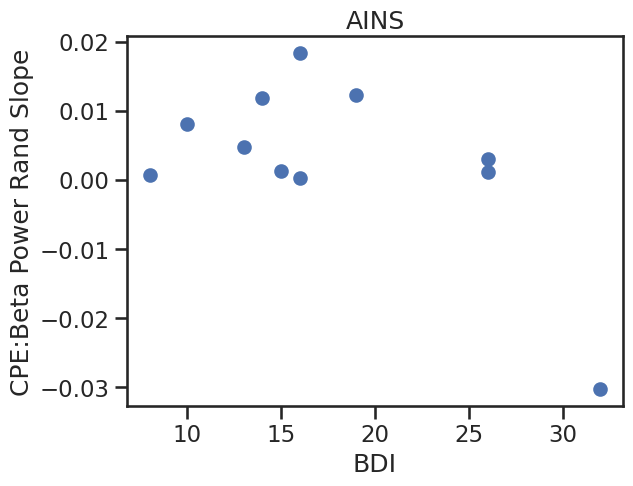

In [133]:
sns.set_context('talk')
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
print(r,p_r)
plt.figure()
plt.scatter(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
plt.title('AINS')
plt.xlabel('BDI')
plt.ylabel('CPE:Beta Power Rand Slope')

In [501]:
list(zip(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values))

[(14, 0.014073753428344486),
 (8, -0.023881216963066335),
 (16, -0.00261742544941908),
 (26, -0.0222769831702146),
 (26, -0.014078973030099489),
 (16, 0.011991609030255677),
 (13, 0.015075412267724159),
 (32, 0.015227517352320233),
 (19, -0.024152111297686695),
 (15, -0.03482032045411541),
 (10, 0.002791211481728208)]

0.03723097358511451 0.9134585283837746


Text(0, 0.5, 'CPE:Beta Power Rand Slope')

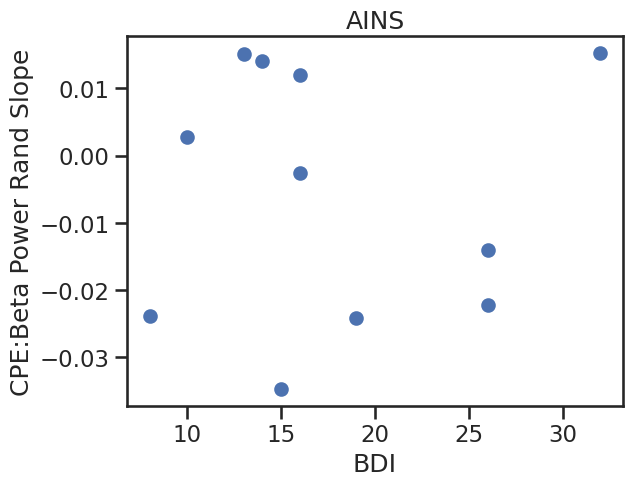

In [504]:
sns.set_context('talk')
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
print(r,p_r)
plt.figure()
plt.scatter(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
plt.title('AINS')
plt.xlabel('BDI')
plt.ylabel('CPE:Beta Power Rand Slope')


In [ ]:
rt_cpe_beta_plot = rt_cpe_beta_results.copy()
# good_roi = full_hfa_model_results['roi'].value_counts().index[full_hfa_model_results['roi'].value_counts()>20].to_list()
rt_cpe_beta_plot = rt_cpe_beta_plot[rt_cpe_beta_plot.roi.isin(roi_list)]
rt_cpe_beta_plot


In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,
              x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Random Slope',fontsize=28,x=0.1)
# plt.xlabel('Region',fontsize=28,y=-0.03)
sns.despine()

In [453]:
pearsonr(subj_info_df.bdi,subj_means_plot.rand_cpe_hfa_slopes)

PearsonRResult(statistic=-0.687140730586925, pvalue=0.0005790675395670582)

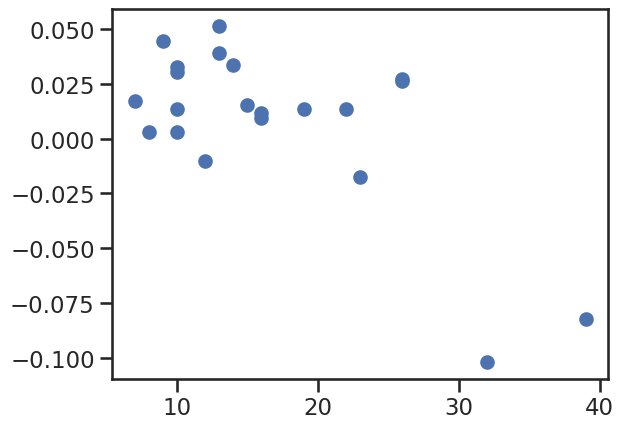

In [454]:
sns.set_context('talk')
plt.scatter(subj_info_df.bdi,subj_means_plot.rand_cpe_hfa_slopes)

In [455]:
roi_subj_means_plot = rt_cpe_hfa_plot.groupby(['subj_id','roi']).agg('mean')
roi_subj_means_plot

rand_intercepts  rand_cpe_slopes  rand_hfa_slopes  \
subj_id roi                                                        
MS002   acc          -0.271854        -0.010971         0.226184   
        ains         -0.276556        -0.010589         0.143936   
        amy          -0.279322        -0.013868         0.061896   
        dlpfc        -0.277818        -0.009575        -0.082667   
        dmpfc        -0.269651        -0.009219         0.167931   
...                        ...              ...              ...   
MS043   dlpfc        -0.319307         0.004699        -0.013602   
        dmpfc        -0.318911         0.008299        -0.005774   
        hpc          -0.316983         0.004862        -0.057422   
        ofc          -0.313151         0.010042         0.037051   
        vlpfc        -0.305838         0.007163         0.220411   

               rand_cpe_hfa_slopes  
subj_id roi                         
MS002   acc               0.087314  
        ains              0.103684  
        amy               0.055260  
        dlpfc             0.020116  
        dmpfc             0.034026  
...                            ...  
MS043   dlpfc            -0.066452  
        dmpfc             0.018956  
        hpc              -0.041143  
        ofc              -0.019569  
        vlpfc            -0.003896  

[183 rows x 4 columns]

In [456]:
# roi_subj_means_plot.index.values
# roi_subj_means_plot.index.get_level_values(level='roi').item
roi_subj_means_plot[roi_subj_means_plot.index.isin(['acc'],level=1)]

,,rand_intercepts,rand_cpe_slopes,rand_hfa_slopes,rand_cpe_hfa_slopes
subj_id,roi,,,,
MS002,acc,-0.271854,-0.010971,0.226184,0.087314
MS003,acc,0.134826,-0.000086,-0.095016,-0.012635
MS009,acc,-0.110866,-0.022762,0.092363,0.063159
MS011,acc,0.186445,-0.030934,0.034655,0.009793
MS015,acc,0.090295,-0.007514,-0.248294,0.086405
MS016,acc,0.440093,0.017934,0.003962,0.038183
MS017,acc,0.086501,-0.004378,0.001412,-0.048092
MS019,acc,-0.120063,0.014277,0.065628,-0.050909
MS022,acc,0.529629,-0.019055,0.056228,0.046272


In [457]:
roi_subj = roi_data.index.get_level_values(level='subj_id').values.tolist()
roi_subj_bdi = subj_info_df.bdi[subj_info_df.subj_id.isin(roi_subj)]
roi_subj_bdi 

2      7
4     13
5     26
8     12
9     10
16    19
17    39
Name: bdi, dtype: int64

acc -0.34762781904069395 0.13313991924252366
dmpfc -0.5182376264894748 0.016098132939839232
amy -0.30583551622918176 0.18973703275039056
ains 0.2406656564542303 0.4759316875050293
vlpfc -0.06855909320876796 0.7739582379522109
hpc -0.4708124094591278 0.04189699946027177
ofc -0.4341872035707192 0.06324644924381048
pins -0.4041935632586297 0.17074584245451044
dlpfc -0.22910719542383695 0.33123368705442224
motor -0.6466585253164127 0.08312558605171379
vmpfc -0.3383399655383184 0.5775784151017439
mcc -0.6532423264402885 0.11160416323526802


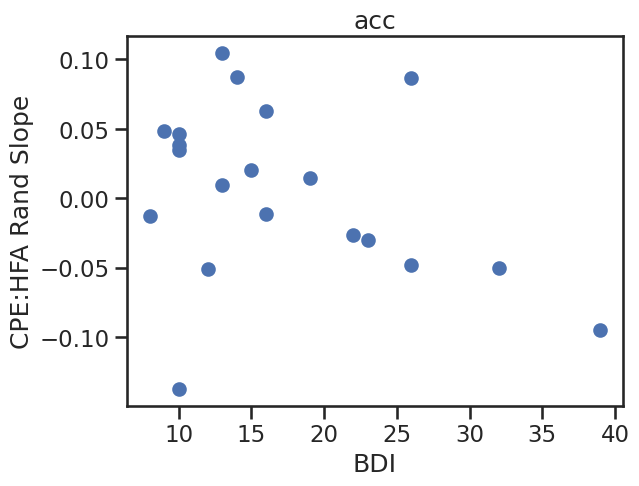

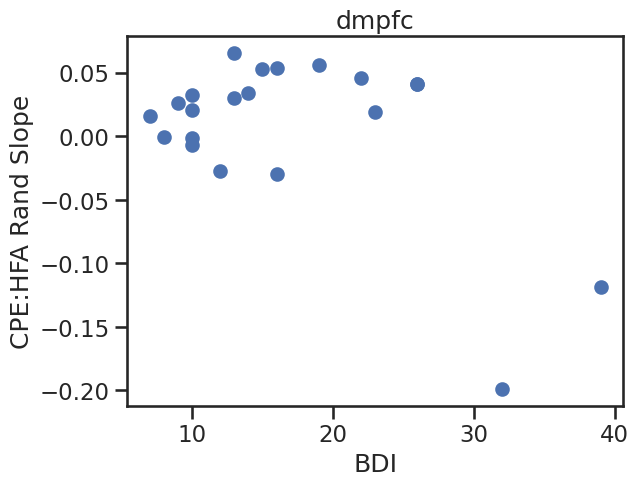

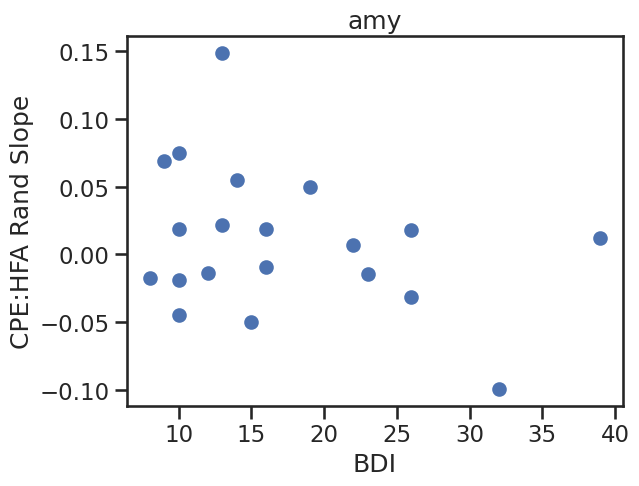

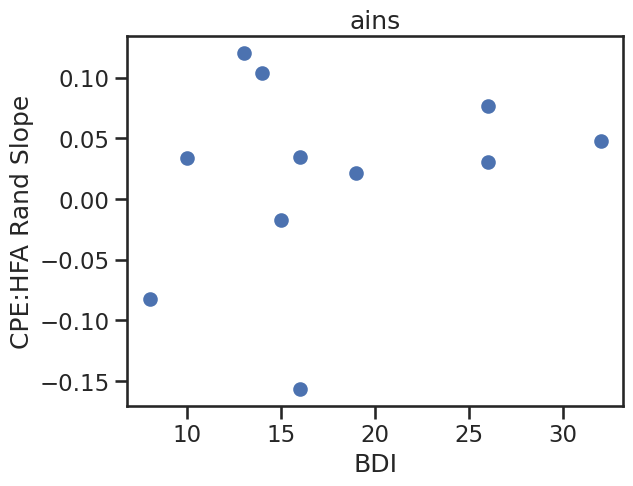

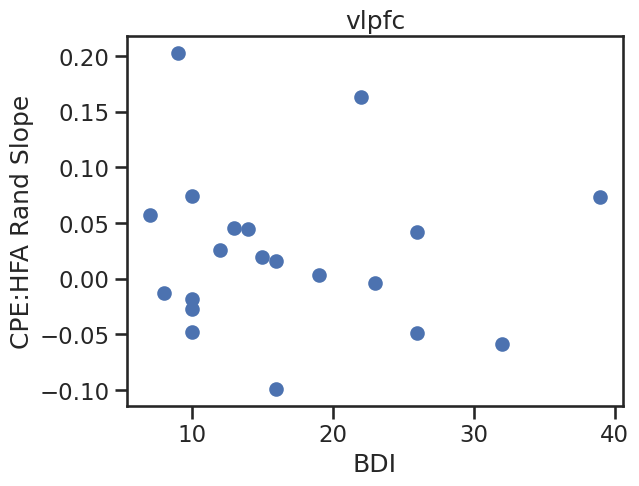

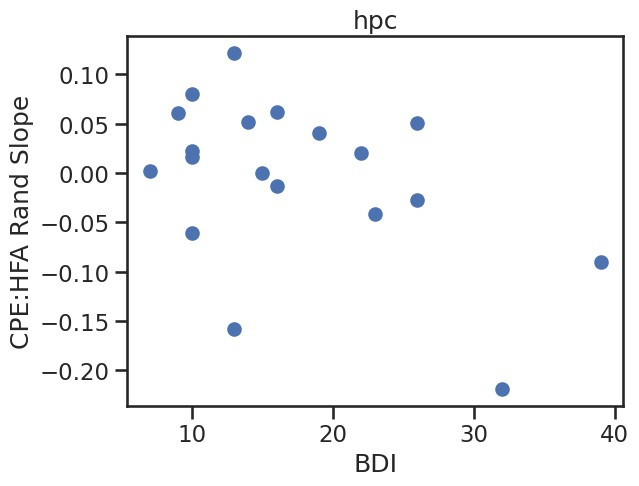

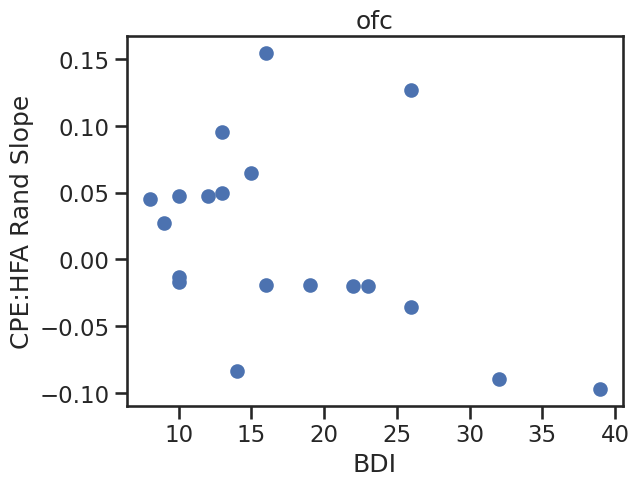

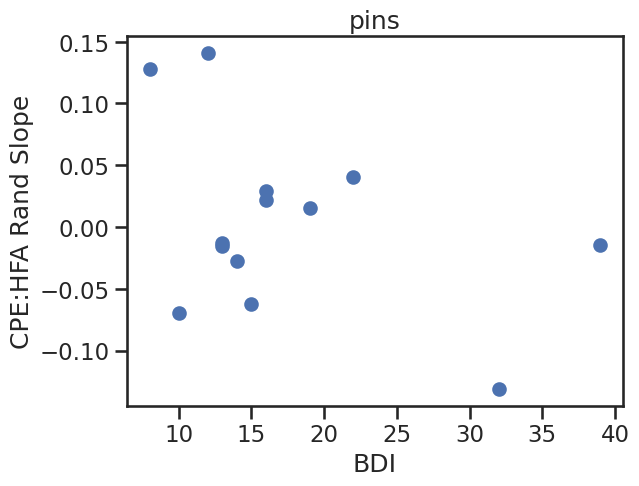

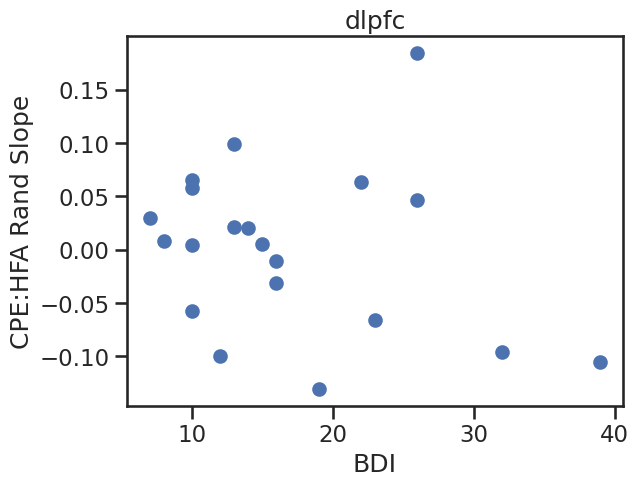

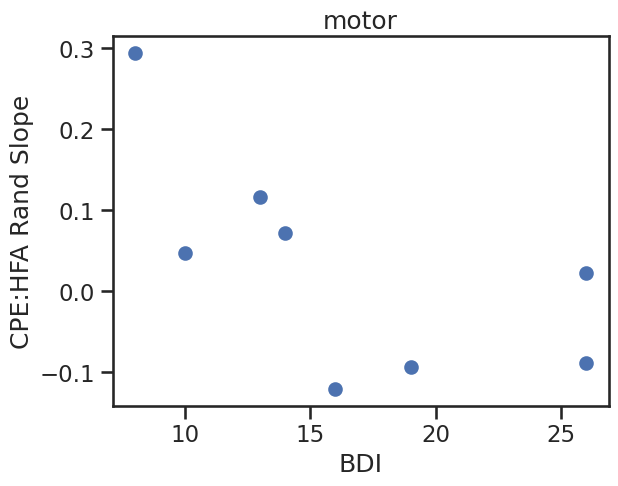

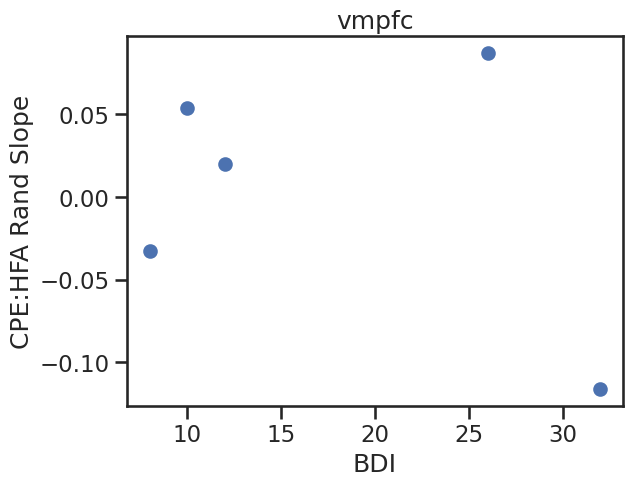

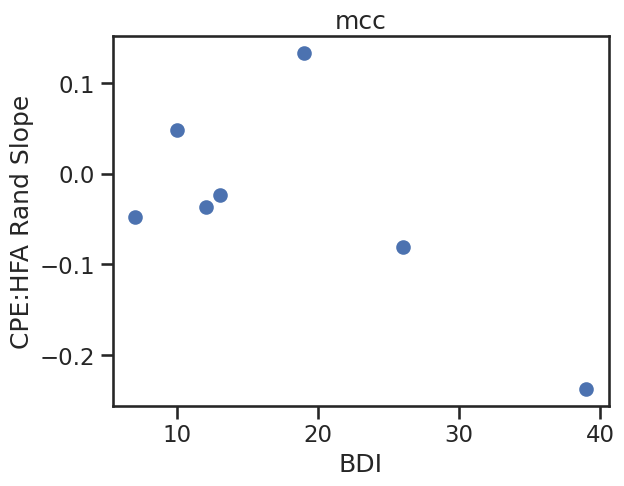

In [458]:

for roi in roi_list:
    roi_data = roi_subj_means_plot[roi_subj_means_plot.index.isin([roi],level=1)]
    roi_subj = roi_data.index.get_level_values(level='subj_id').values.tolist()
    roi_subj_bdi = subj_info_df.bdi[subj_info_df.subj_id.isin(roi_subj)].tolist()
    r,p_r = pearsonr(roi_subj_bdi,roi_data.rand_cpe_hfa_slopes.values)
    print(roi,r,p_r)
    plt.figure()
    plt.scatter(roi_subj_bdi,roi_data.rand_cpe_hfa_slopes.values)
    plt.title(f'{roi}')
    plt.xlabel('BDI')
    plt.ylabel('CPE:HFA Rand Slope')
    
    

In [ ]:
sns.set_context('talk')
plt.scatter(subj_info_df.bdi,subj_means_plot.rand_cpe_hfa_slopes)